# Clustering of imaging data

In [1]:
import numpy as np                     # scientific computing toolkit
import pandas as pd                    # data analysis toolkit
import scanpy as sc                    # scanpy is referred to with sc.***
import matplotlib.pyplot as plt        # Matplotlib is referred to with plt.***
from sklearn import preprocessing
from scipy import stats
import seaborn as sns
import math

sc.settings.verbosity = 0              # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()            # check if all needed versions are installed and up to date

scanpy==1.4.6 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22.2 statsmodels==0.11.1 python-igraph==0.8.0


In [2]:
sc.settings.set_figure_params(dpi=40, color_map='viridis')

## Import and preprocessing:

#### Read the files for channels, FL_values and distances generated in ImageJ as pandas DataFrames:

In [3]:
data=pd.read_csv('./data/FL_values.csv',)
channels=pd.read_csv('./data/channels.csv')
gatings=pd.read_csv('./data/gatings.csv',sep=';')
gatings=gatings.fillna(0).astype(int)
gatings=gatings-1
gatings=gatings.astype(str)
cellnumber=int(data.shape[0]/channels.shape[0])

/Users/Sebastian/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Generate a matrix with the mean intensity values for each channel listed in additional columns and reshape the DataFrame:

In [4]:
matrix=pd.DataFrame(data[:cellnumber])
for i in range(0,channels.shape[0]):
    matrix[str(channels.iloc[i,0])]=0.000
    matrix[str(channels.iloc[i,0])][:cellnumber]=data.Mean[i*cellnumber:(i+1)*cellnumber]

/Users/Sebastian/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [5]:
#Drop columns which will not be used in the adata object and replace NaN with a 0
matrix.fillna(0,inplace=True)
matrix_new = matrix.drop(matrix.iloc[:, 0:35], axis=1)
matrix.rename(columns={'Circ.':'Circularity'}, inplace=True)
matrix_new = matrix_new[matrix_new.columns.drop(list(matrix_new.filter(regex='min_Dist')))]
matrix_normalized=matrix_new
matrix_normalized.index = pd.RangeIndex(len(matrix_normalized.index))

#Normalize the values within each marker 
for i in range(0,channels.shape[0]):
    df=matrix_new[str(channels.iloc[i,0])]
    matrix_normalized[str(channels.iloc[i,0])]=(df-df.min())/(df.max()-df.min())*100000

#export matrix to read in again as adata object
matrix_normalized.to_csv('./export/matrix.csv')

#### Read in matrix as scanpy object and save some variables from the initial matrix as adata.obs:

In [6]:
adata=sc.read_csv('./export/matrix.csv',first_column_names=True)
adata.obs['X']=matrix.X.values.tolist()
adata.obs['Y']=matrix.Y.values.tolist()
adata.obs['area']=matrix.Area.values.tolist()
adata.obs['circularity']=matrix.Circularity.values.tolist()
adata.obs['Annotation']='Dirt'
adata.obs['Gated_population_1']='not_gated'
adata.obs['Gated_population_2']='not_gated'

#### Import gatings if provided:

In [7]:
pd.set_option('mode.chained_assignment', None)
adata.obs.Annotation[adata.obs_names.isin(gatings.Area_1)]='Area_1'
adata.obs.Annotation[adata.obs_names.isin(gatings.Area_2)]='Area_2'
adata.obs.Annotation[adata.obs_names.isin(gatings.Dirt)]='Dirt'

In [8]:
adata.obs.Gated_population_1[adata.obs_names.isin(gatings.LP)]='Lamina propria'
adata.obs.Gated_population_1[adata.obs_names.isin(gatings.lymphocytes)]='Lymphocytes'
adata.obs.Gated_population_1[adata.obs_names.isin(gatings.epithelial)]='Epithelial cells'
adata.obs.Gated_population_1[adata.obs_names.isin(gatings.muscular)]='Muscular cells'

In [9]:
adata.obs.Gated_population_2[adata.obs_names.isin(gatings.B_cells_2)]='B cells'
adata.obs.Gated_population_2[adata.obs_names.isin(gatings.T_cells_2)]='T cells'
adata.obs.Gated_population_2[adata.obs_names.isin(gatings.Macrophages_2)]='Macrophages'
adata.obs.Gated_population_2[adata.obs_names.isin(gatings.Monocytes_2)]='Monocytes'
adata.obs.Gated_population_2[adata.obs_names.isin(gatings.Tregs)]='Tregs'

In [10]:
sc.pp.filter_cells(adata, min_genes=3)

#### Check for markers with the highest expression over the tissue:

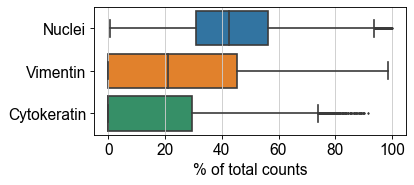

In [11]:
sc.pl.highest_expr_genes(adata, n_top=3)

#### Filter cells according to theire total brighness, area and circularity and process values for further analysis:

... storing 'Annotation' as categorical
... storing 'Gated_population_1' as categorical
... storing 'Gated_population_2' as categorical


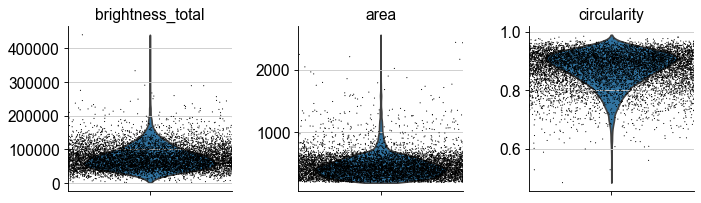

In [12]:
adata.obs['brightness_total'] = adata.X.sum(axis=1)
sc.pl.violin(adata, ['brightness_total','area','circularity'], jitter=0.8, multi_panel=True)

In [13]:
adata = adata[adata.obs['brightness_total'] < 200000, :]
adata = adata[adata.obs['area'] < 800, :]
adata = adata[adata.obs['circularity'] > 0.75, :]

In [14]:
var_data=pd.DataFrame(adata.X) #save var data for later merging with neighborhood matrix

In [15]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)

/Users/Sebastian/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


## Generate distance matrix

In [16]:
calculate=False #Needs to be true to calculate the distances the first time. Set to false afterwards in order to save time

In [17]:
if calculate == True:
    distances=np.empty([len(adata.obs_names),len(adata.obs_names)])
    x_values=adata.obs.X
    y_values=adata.obs.Y
    for j in range (distances.shape[0]):
        distances[j,j:] = ((x_values[j:].apply(lambda x: (x-x_values[j])**2))+(y_values[j:].apply(lambda y: (y-y_values[j])**2)))**(.5)
        print("Progress: {:2.1%}".format(j/distances.shape[0]), end="\r")

In [18]:
# Make the matrix symetric
if calculate == True:
    arr = distances
    arr2 = np.triu(arr) + np.triu(arr,1).T
    distances_completed=pd.DataFrame(arr2)
    distances_completed.columns=adata.obs_names
    distances_completed.index=adata.obs_names
    distances_completed.to_csv('./export/distances_completed.csv')

In [19]:
distances_completed = pd.read_csv('./export/distances_completed.csv',index_col=0)

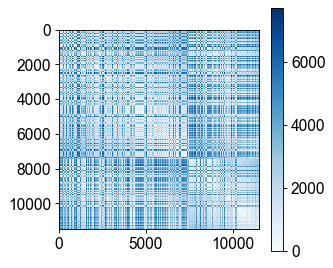

In [20]:
plt.imshow(distances_completed.astype(float), zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.show()

# Visualisation and Dimensional reduction

#### Plot cells and check if the tissue architechture is preserved, or if too many cells have been filtered out:

/Users/Sebastian/miniconda3/lib/python3.7/site-packages/scanpy/plotting/_utils.py:734: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_cb = fig.add_axes(rectangle)
/Users/Sebastian/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


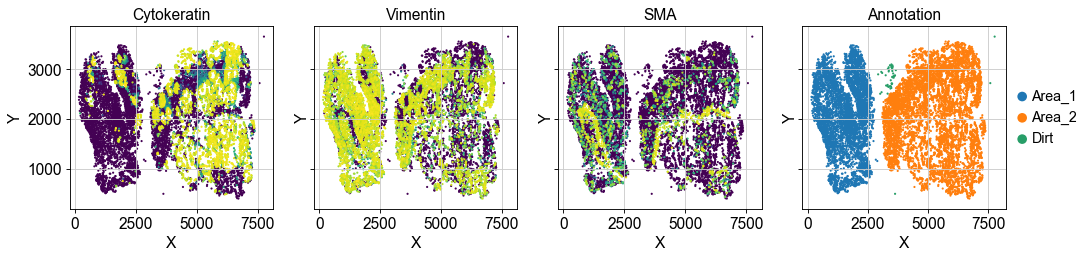

In [21]:
fig, axes = plt.subplots(ncols=4, figsize=(15, 3), sharey=True)

ax1, ax2, ax3, ax4 = axes
sc.pl.scatter(adata, 'X', 'Y', color='Cytokeratin', color_map='viridis', ax=ax1, show=False, size=15)
sc.pl.scatter(adata, 'X', 'Y', color='Vimentin', color_map='viridis', ax=ax2, show=False, size=15)
sc.pl.scatter(adata, 'X', 'Y', color='SMA', color_map='viridis', ax=ax3, show=False, size=15)
sc.pl.scatter(adata, 'X', 'Y', color='Annotation', color_map='viridis', ax=ax4, show=False, size=15)
fig.delaxes(fig.axes[4]) 
fig.show()

#### Run PCA, neighborhood embedding, UMAP and leiden clustering:

In [22]:
sc.tl.pca(adata)

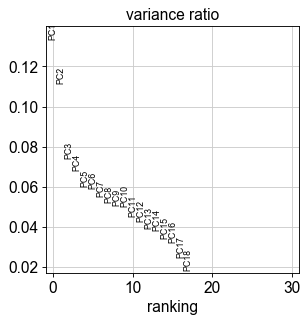

In [23]:
sc.pl.pca_variance_ratio(adata)

In [24]:
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=7)

/Users/Sebastian/miniconda3/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../miniconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/Users/Sebastian/miniconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../miniconda3/lib/python3.7/site-packag

In [25]:
sc.tl.umap(adata, min_dist=1.7)

In [26]:
sc.tl.leiden(adata)

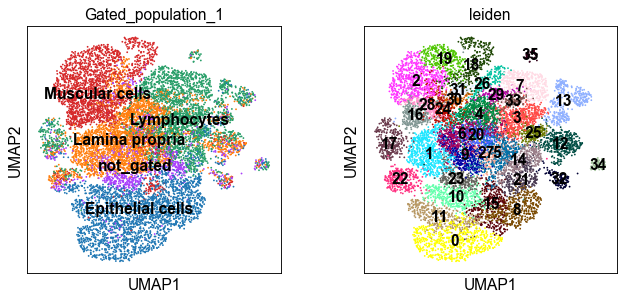

In [27]:
sc.pl.umap(adata, color=['Gated_population_1', 'leiden'], ncols=2, legend_loc='on data')

#### Analyze and plot marker genes to annotate cell populations:
(for more ways of analyzing marker genes have a look at the scanpy documentation)

/Users/Sebastian/miniconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


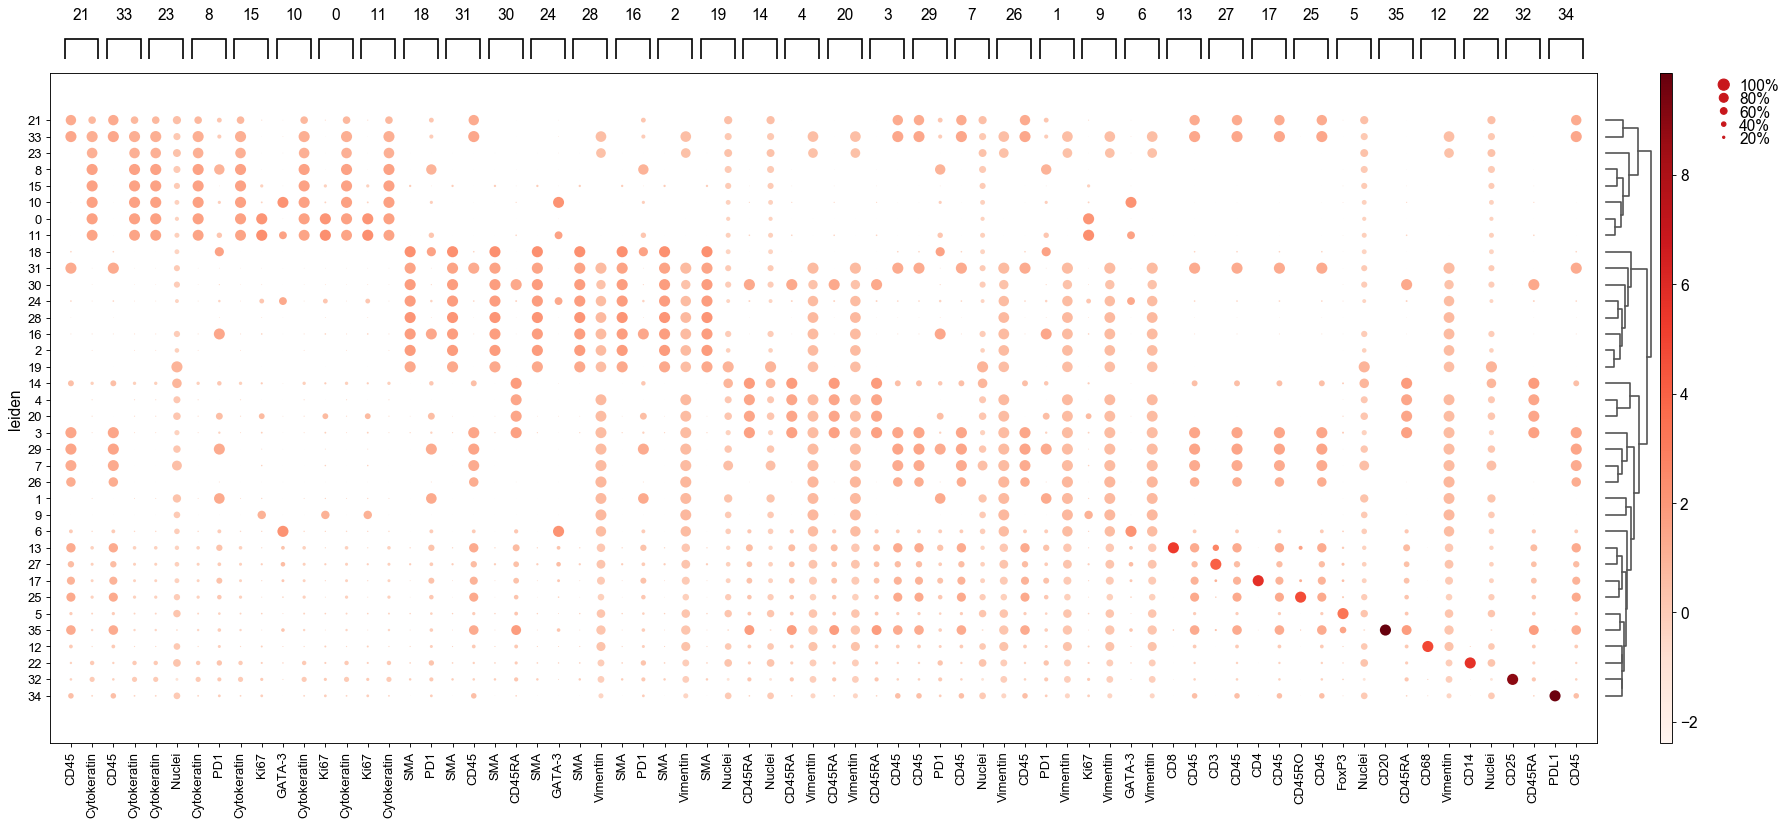

In [28]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata, n_genes=2)

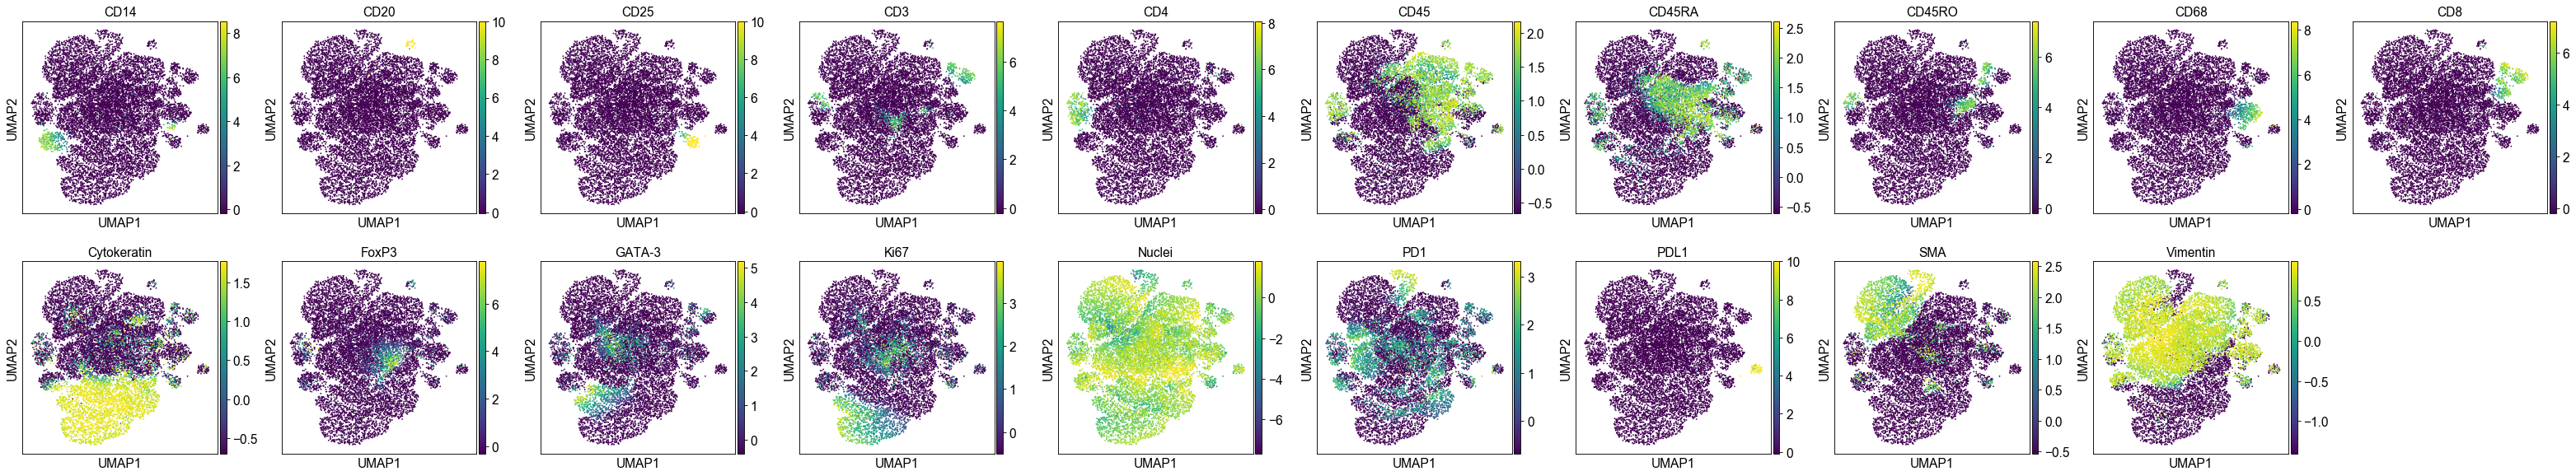

In [29]:
sc.pl.umap(adata, color=adata.var_names, ncols=10)

In [30]:
adata=adata[adata.obs.leiden!='32']

#### Annotate clusters and change colors for cell populations:

In [31]:
pd.set_option('mode.chained_assignment', None)
adata.obs['celltype_Level_1']='undefined'
adata.obs.celltype_Level_1[adata.obs.leiden.isin(['0','11','8','15','10','21'])]='Epithelial cells'
adata.obs.celltype_Level_1[adata.obs.leiden.isin(['19','2','16','18','30','31','28','24'])]='muscular cells'
adata.obs.celltype_Level_1[adata.obs.leiden.isin(['1','6','33','27','33','23','9','5'])]='Lamina propria cells'
adata.obs.celltype_Level_1[adata.obs.leiden.isin(['13','12','7','25','34','26','29','17','3','4','20','14','35','22','26'])]='Lymphocytes'

Trying to set attribute `.obs` of view, copying.


In [32]:
adata.obs['celltype_epithelial']='non-epithelial cells'
adata.obs.celltype_epithelial[adata.obs.leiden.isin(['21'])]='intraepithelial Lymphocytes'
adata.obs.celltype_epithelial[adata.obs.leiden.isin(['11'])]='Ki67++ epithelial'
adata.obs.celltype_epithelial[adata.obs.leiden.isin(['10'])]='GATA3+ epithelial'
adata.obs.celltype_epithelial[adata.obs.leiden.isin(['0'])]='Ki67+ epithelial'
adata.obs.celltype_epithelial[adata.obs.leiden.isin(['15'])]='SMA+ epithelial'
adata.obs.celltype_epithelial[adata.obs.leiden.isin(['8'])]='PD1+ epithelial'

In [33]:
adata.obs['celltype_muscular']='non-muscular cells'
adata.obs.celltype_muscular[adata.obs.leiden.isin(['18'])]='PD1+ muscular'
adata.obs.celltype_muscular[adata.obs.leiden.isin(['19'])]='SMA low muscular'
adata.obs.celltype_muscular[adata.obs.leiden.isin(['31'])]='intramuscular Lymphocytes'
adata.obs.celltype_muscular[adata.obs.leiden.isin(['19','2','16','30','28','24'])]='other muscular'

In [34]:
adata.obs['celltype_lymphocytes']='CD45- cells'
adata.obs.celltype_lymphocytes[adata.obs.leiden.isin(['31'])]='intramuscular Lymphocytes'
adata.obs.celltype_lymphocytes[adata.obs.leiden.isin(['21'])]='intraepithelial Lymphocytes'
adata.obs.celltype_lymphocytes[adata.obs.leiden.isin(['13'])]='CD8 T cells'
adata.obs.celltype_lymphocytes[adata.obs.leiden.isin(['25'])]='memory Lymphocytes'
adata.obs.celltype_lymphocytes[adata.obs.leiden.isin(['17'])]='CD4 T cells'
adata.obs.celltype_lymphocytes[adata.obs.leiden.isin(['22'])]='Monocytes'
adata.obs.celltype_lymphocytes[adata.obs.leiden.isin(['12'])]='Macrophages'
adata.obs.celltype_lymphocytes[adata.obs.leiden.isin(['35'])]='B cells'
adata.obs.celltype_lymphocytes[adata.obs.leiden.isin(['34'])]='PD-L1+ cells'
adata.obs.celltype_lymphocytes[adata.obs.leiden.isin(['20'])]='Tregs'
adata.obs.celltype_lymphocytes[adata.obs.leiden.isin(['4','20','14','3'])]='naive Lymphocytes'
adata.obs.celltype_lymphocytes[adata.obs.leiden.isin(['7','26','29'])]='other Lymphocytes'

In [35]:
adata.obs['celltype_Level_2']='not specified'

In [36]:
adata.obs.celltype_Level_2[adata.obs.celltype_epithelial != 'non-epithelial cells']=adata.obs.celltype_epithelial
adata.obs.celltype_Level_2[adata.obs.celltype_muscular != 'non-muscular cells']=adata.obs.celltype_muscular
adata.obs.celltype_Level_2[adata.obs.celltype_lymphocytes != 'CD45- cells']=adata.obs.celltype_lymphocytes
adata.obs.celltype_Level_2[adata.obs.leiden.isin(['1','6','33','27','33','23','9','5'])]='Lamina propria cells'

In [37]:
adata.uns['celltype_epithelial_colors']=['#1f77b4','#ff7f0e','#279e68','#d62728','#aa40fc','#8c564b','#d1d1d1']
adata.uns['celltype_muscular_colors']=['#1f77b4', '#ff7f0e', '#d1d1d1', '#d62728']
adata.uns['celltype_Level_2_colors']=['#1f77b4','#b41f1f','#b4821f','#279e68','#c4d627','#aa40fc','#8c564b','#e377c2','#b5bd61','#130b75','#0b6a75','#0b7510','#750b73','#750b0b','#c5b0d5','#c49c94','#f7b6d2','#dbdb8d','#9edae5']
adata.uns['celltype_lymphocytes_colors']=['#1f77b4','#b41f1f','#b4821f','#d1d1d1','#279e68','#c4d627','#aa40fc','#8c564b','#e377c2','#b5bd61','#130b75','#0b6a75']
adata.uns['Gated_population_2_colors']=['#1f77b4','#279e68','#c4d627','#d62728','#aa40fc','#d1d1d1']
adata.uns['Gated_population_1_colors']=['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#d1d1d1']

... storing 'celltype_Level_1' as categorical
... storing 'celltype_epithelial' as categorical
... storing 'celltype_muscular' as categorical
... storing 'celltype_lymphocytes' as categorical
... storing 'celltype_Level_2' as categorical


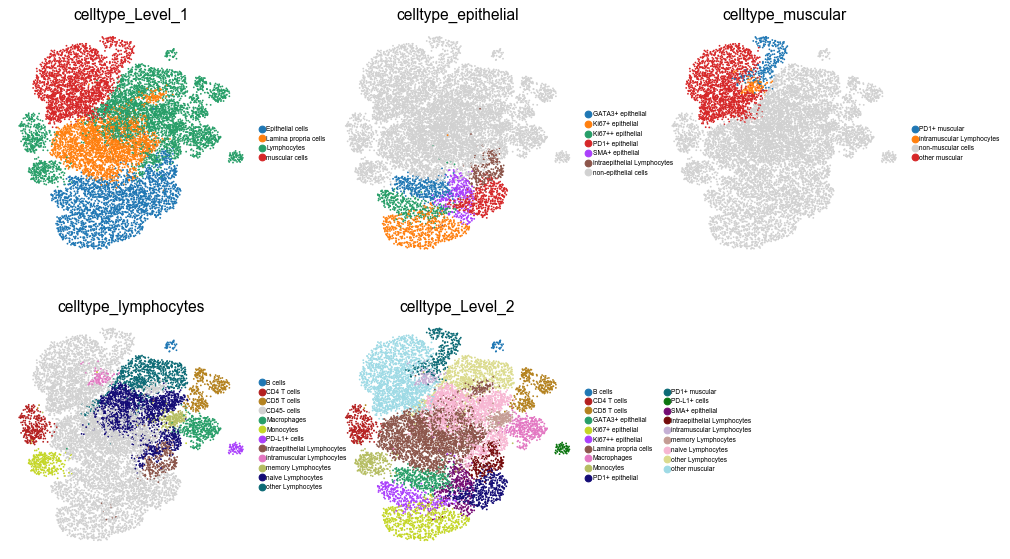

In [38]:
sc.pl.umap(adata, color=['celltype_Level_1','celltype_epithelial','celltype_muscular', 'celltype_lymphocytes','celltype_Level_2'], legend_fontsize=6, frameon=False, ncols=3)

# Generate neighborhood data from distances

In [39]:
cells_of_interest = ['9395','2397','2609','13019'] #cells selected from different tissue regions
x=60 #set the radius (represents a 30µm range)

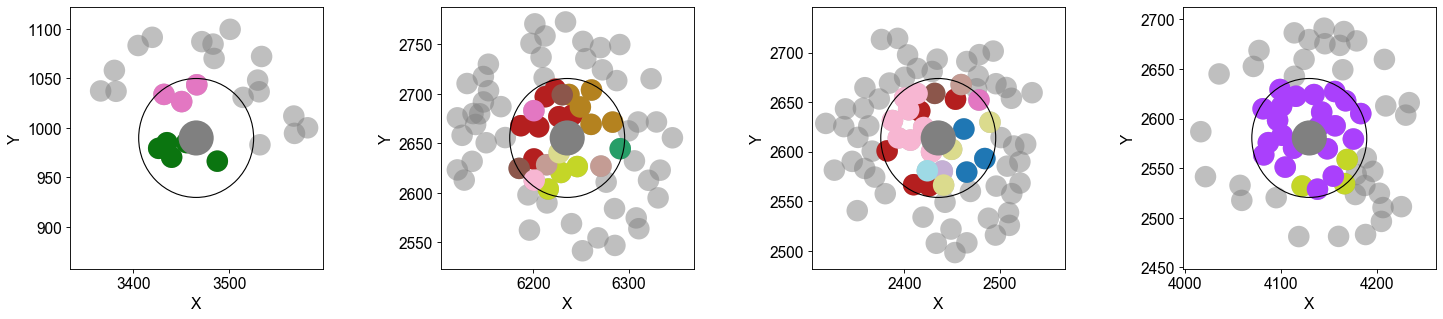

In [40]:
fig, ax = plt.subplots(ncols=4, figsize=(18, 4))
fig.tight_layout(w_pad=5)
for i, cell in enumerate(cells_of_interest):
    ax[i].set_xlim([adata.obs.loc[cell]['X']-2.2*x,adata.obs.loc[cell]['X']+2.2*x])
    ax[i].set_ylim([adata.obs.loc[cell]['Y']-2.2*x,adata.obs.loc[cell]['Y']+2.2*x])
    circle = plt.Circle((adata.obs.loc[cell]['X'], adata.obs.loc[cell]['Y']), x, edgecolor="black", facecolor='none')
    sc.pl.scatter(adata[adata.obs_names.isin(distances_completed.loc[distances_completed[cell]<=(2*x),cell].index.values.astype(str))], 'X', 'Y', size=1500, alpha=0.5, ax=ax[i], show=False)
    sc.pl.scatter(adata[adata.obs_names.isin(distances_completed.loc[distances_completed[cell]<=x,cell].index.values.astype(str))], 'X', 'Y', color='celltype_Level_2', size=1500, ax=ax[i], show=False)
    sc.pl.scatter(adata[adata.obs_names.isin([cell])], 'X', 'Y', size=4000, ax=ax[i], show=False)
    ax[i].add_artist(circle)
    ax[i].grid(False)
    ax[i].get_legend().remove()

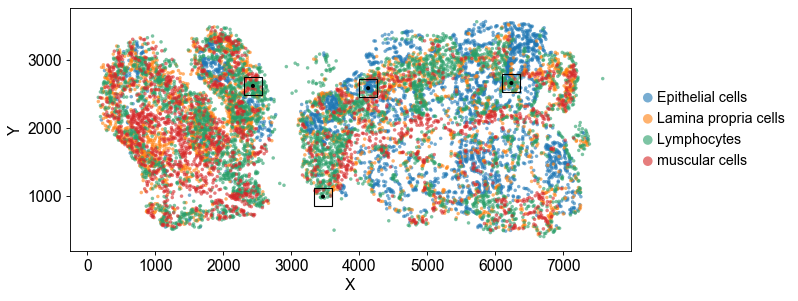

In [41]:
fig, ax = plt.subplots(figsize=(9, 4))
sc.pl.scatter(adata, 'X', 'Y', color='celltype_Level_1', title='', alpha=0.6, size=40, ax=ax, show=False)
for cell in cells_of_interest:
    rectangle=plt.Rectangle((adata.obs.loc[cell]['X']-2.2*x, adata.obs.loc[cell]['Y']-2.2*x), x*4.4, x*4.4, edgecolor='black', facecolor='none')
    circle = plt.Circle((adata.obs.loc[cell]['X'], adata.obs.loc[cell]['Y']), 30, edgecolor="none", facecolor='black')
    ax.add_artist(circle)
    ax.add_artist(rectangle)
ax.grid(False)

#### Generate the environment matrix:

In [42]:
distances_completed_na=distances_completed.replace(0,np.nan) #cells shouldnt be counted as their own neighbors
distances_completed_na[distances_completed_na>=x]=np.nan #exclude distances greater than the selected radius x

In [43]:
neighbours=pd.DataFrame()
for i in range(adata.obs.leiden.nunique()):
    neighbours[i]=distances_completed_na.loc[:,adata.obs_names[adata.obs.leiden==np.sort(adata.obs.leiden.unique().astype(int)).astype(str)[i]].values].count(axis=1)

In [44]:
neighbours=neighbours*1000
leiden_names=pd.DataFrame(adata.obs.groupby(['celltype_Level_2', 'leiden']).describe().iloc[:,:0]).reset_index().sort_values('leiden').reset_index(drop=True)
colnames = []
for i in range(leiden_names.shape[0]):
    colnames.append(leiden_names.celltype_Level_2[i]+' Cluster '+leiden_names.leiden[i])

In [45]:
#Process and merge the adata.var matrix with the distance matrix
var_data.columns=adata.var_names
var_data.index=neighbours.index
neighbours.columns=colnames
var_data_merged=pd.concat([neighbours, var_data], axis=1)
var_data_merged=var_data_merged[var_data_merged.index.isin(adata.obs_names)]
var_data_merged.to_csv('./export/var_data_merged.csv', index=False)
adata_neigbours=sc.read_csv('./export/var_data_merged.csv')
sc.pp.normalize_total(adata_neigbours, target_sum=1e4)
sc.pp.log1p(adata_neigbours)
sc.pp.scale(adata_neigbours, max_value=10)
adata_neigbours.obs=adata.obs
adata_neigbours.uns=adata.uns
adata_neigbours.var['feature_types']='gene_expression'
adata_neigbours.var['feature_types'][:adata_neigbours.obs.leiden.nunique()]='distance'

# Cluster neighborhood matrix

In [46]:
adata_neigbours_only=adata_neigbours[:,adata_neigbours.var.feature_types=='distance']

In [47]:
adata_neigbours_only.obs['n_counts'] = adata_neigbours_only.X.sum(axis=1)

Trying to set attribute `.obs` of view, copying.


In [48]:
clusters_OI=adata_neigbours_only.var_names[[11,34,13,17]]

In [49]:
sc.tl.pca(adata_neigbours_only, svd_solver='arpack')

In [50]:
sc.pp.neighbors(adata_neigbours_only, n_neighbors=50, n_pcs=20)

/Users/Sebastian/miniconda3/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../miniconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


In [51]:
sc.tl.umap(adata_neigbours_only, min_dist=0.5)

In [52]:
sc.tl.leiden(adata_neigbours_only, key_added='leiden_neighbours', resolution=0.3)

In [53]:
sc.tl.leiden(adata_neigbours_only, key_added='leiden_neighbours_high_res', resolution=6)

... storing 'feature_types' as categorical


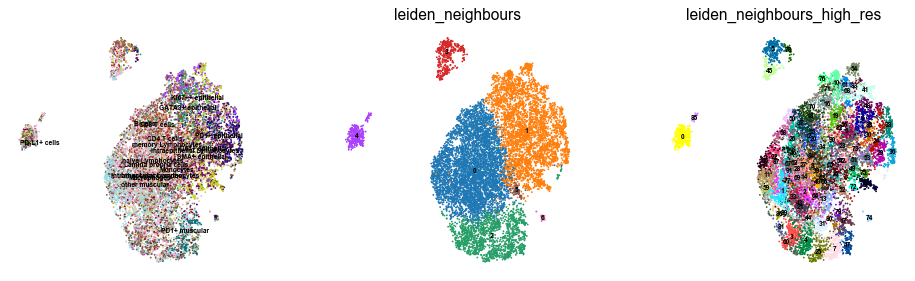

In [54]:
sc.pl.umap(adata_neigbours_only, color=['celltype_Level_2','leiden_neighbours','leiden_neighbours_high_res'], legend_loc='on data', title='', legend_fontsize=6, frameon=False)

In [55]:
def plot_neighbours(cell, ax):
    x=60
    ax.set_xlim([adata.obs.loc[cell]['X']-1.2*x,adata.obs.loc[cell]['X']+1.2*x])
    ax.set_ylim([adata.obs.loc[cell]['Y']-1.2*x,adata.obs.loc[cell]['Y']+1.2*x])
    sc.pl.scatter(adata[adata.obs_names.isin(distances_completed_na.loc[distances_completed_na[cell]<=(2*x),cell].index.values.astype(str))], 'X', 'Y', size=400, alpha=0.5, ax=ax, show=False)
    sc.pl.scatter(adata[adata.obs_names.isin(distances_completed_na.loc[distances_completed_na[cell]<=x,cell].index.values.astype(str))], 'X', 'Y', color='celltype_Level_2', size=400, ax=ax, show=False)
    sc.pl.scatter(adata[adata.obs_names.isin([cell])], 'X', 'Y', size=800, ax=ax, show=False)
    ax.grid(False)
    ax.get_legend().remove()
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_xlabel('')

Environment cluster 78


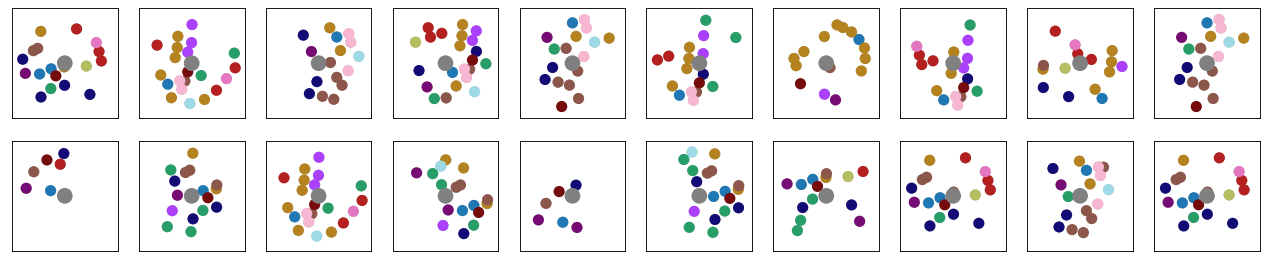

Environment cluster 85


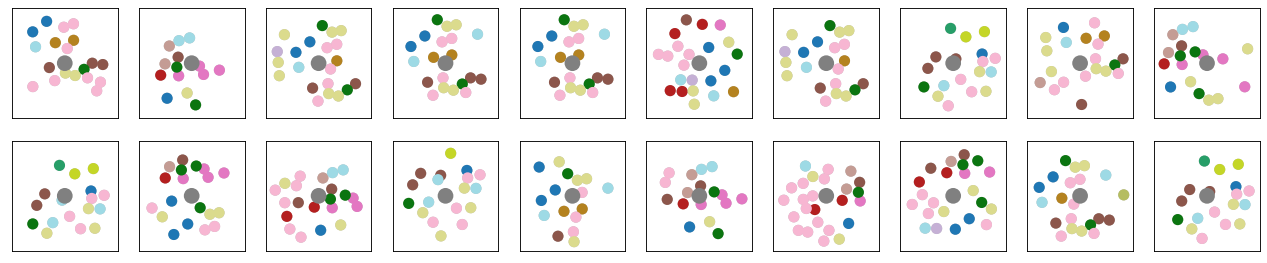

Environment cluster 73


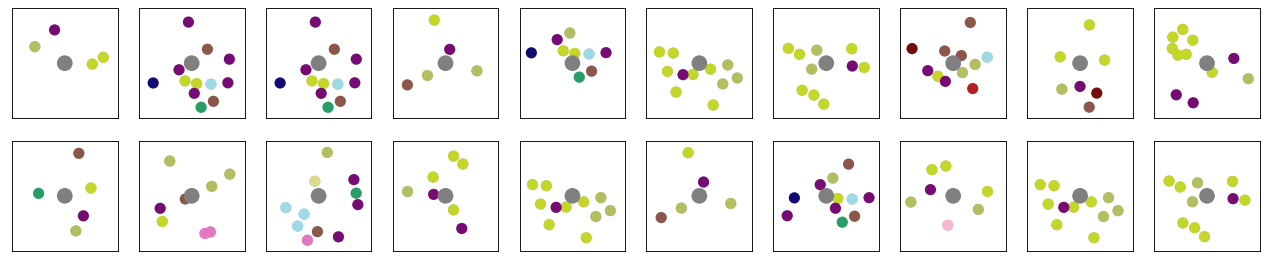

Environment cluster 72


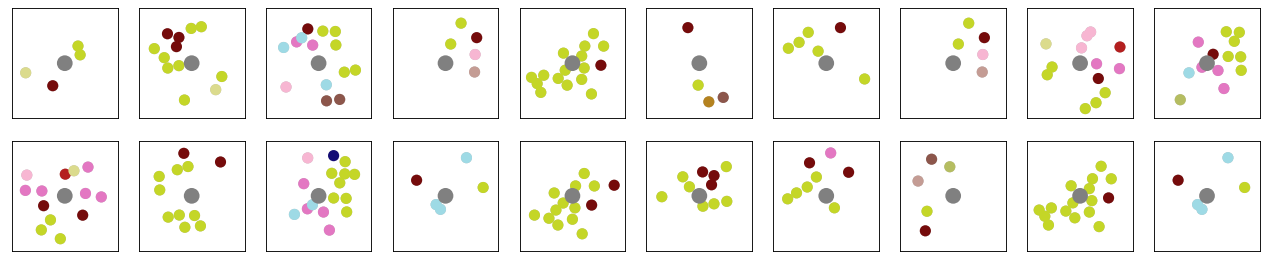

Environment cluster 7


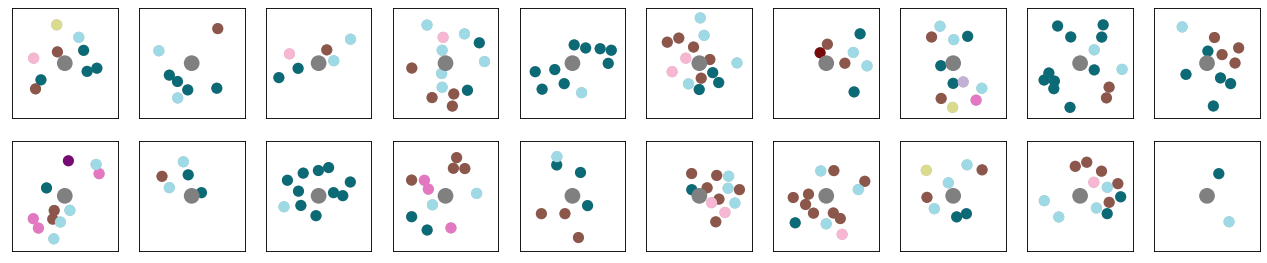

In [56]:
for j in [78,85,73,72,7]:
    print('Environment cluster '+str(j))
    fig, ax = plt.subplots(ncols=10,nrows=2, figsize=(20,4))
    i=0
    for cell in np.random.choice(adata_neigbours_only[adata_neigbours_only.obs.leiden_neighbours_high_res==str(j)].obs_names.values, size=20):
        plot_neighbours(cell, ax.reshape(-1)[i])
        i=i+1
    plt.show()

## Subgroup to CD3 positive cells

In [57]:
adata_neighbour_CD3=adata_neigbours[adata_neigbours.obs.celltype_lymphocytes.isin(['CD4 T cells', 'CD8 T cells'])]
adata_neighbour_CD3=adata_neighbour_CD3[adata_neighbour_CD3[: , 'CD3'].X.toarray()[:,0] >=0.5, :] 

In [58]:
adata_neighbour_CD3_noprot=adata_neighbour_CD3[:,adata_neighbour_CD3.var.feature_types=='distance']

In [59]:
sc.tl.pca(adata_neighbour_CD3_noprot, svd_solver='arpack');

In [60]:
sc.pp.neighbors(adata_neighbour_CD3_noprot, n_neighbors=50, n_pcs=10)

In [61]:
sc.tl.umap(adata_neighbour_CD3_noprot, min_dist=0.8)

In [62]:
sc.tl.leiden(adata_neighbour_CD3_noprot, key_added='leiden_CD3_neighbour', resolution=1)

... storing 'feature_types' as categorical


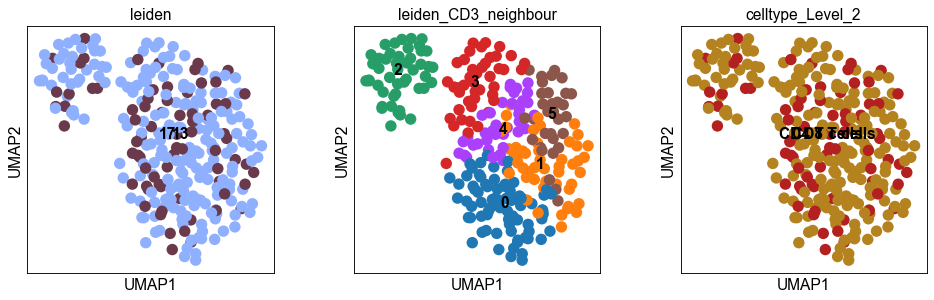

In [63]:
sc.pl.umap(adata_neighbour_CD3_noprot, color=['leiden','leiden_CD3_neighbour','celltype_Level_2'], legend_loc='on data')

/Users/Sebastian/miniconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


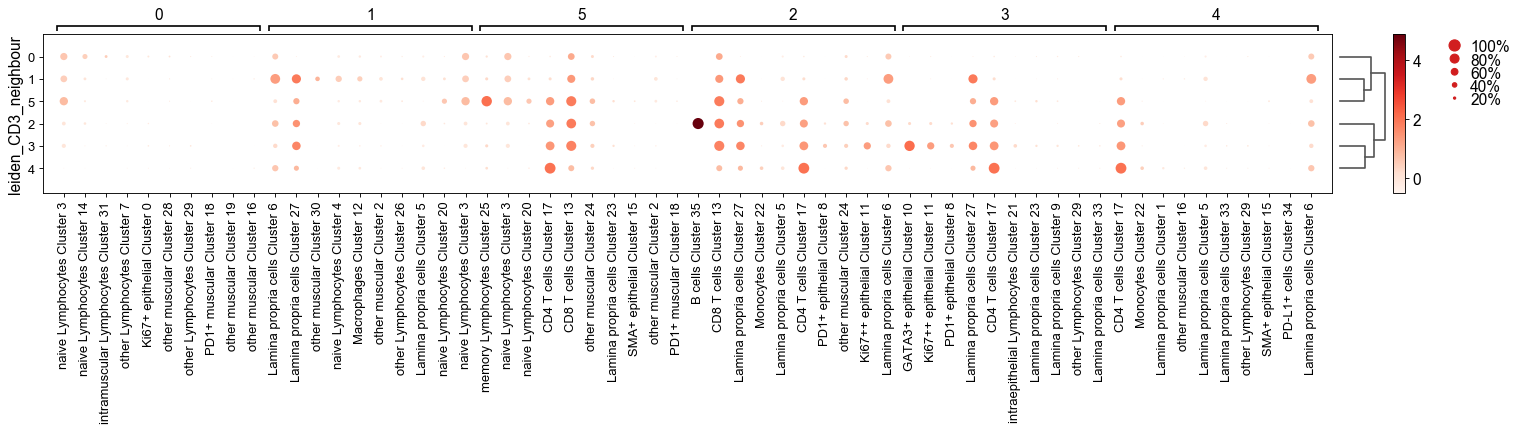

In [64]:
sc.tl.rank_genes_groups(adata_neighbour_CD3_noprot, 'leiden_CD3_neighbour', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata_neighbour_CD3_noprot, n_genes=10)

Environment cluster 0


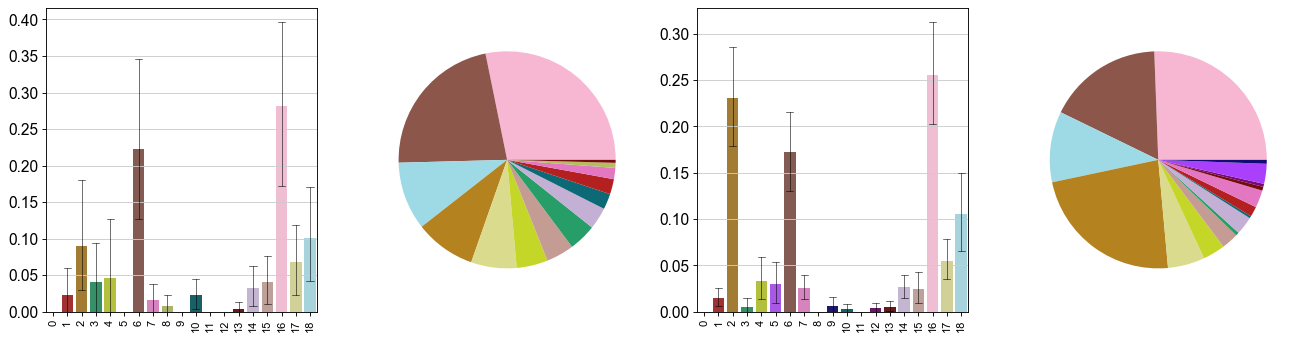

Environment cluster 1


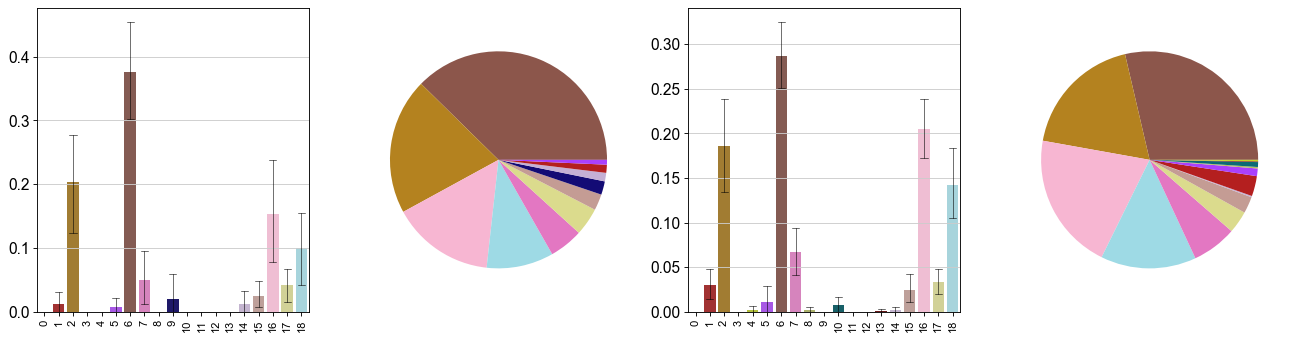

Environment cluster 2


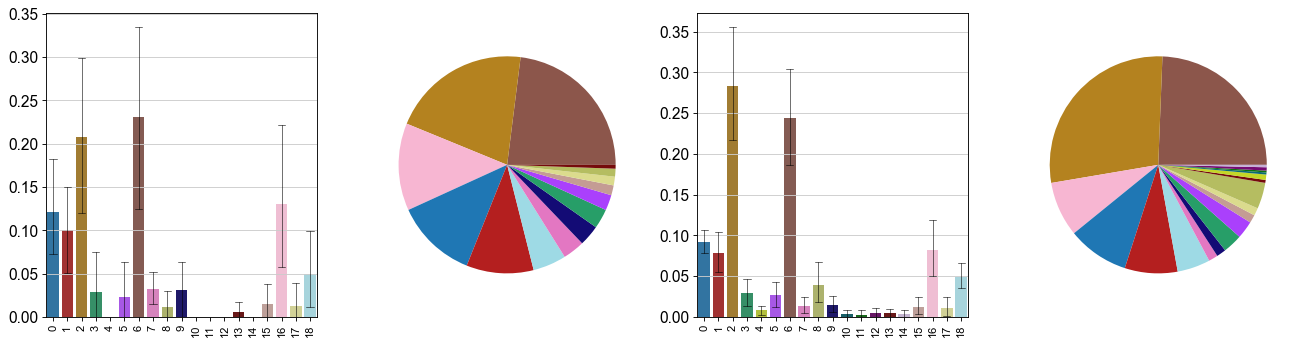

Environment cluster 3


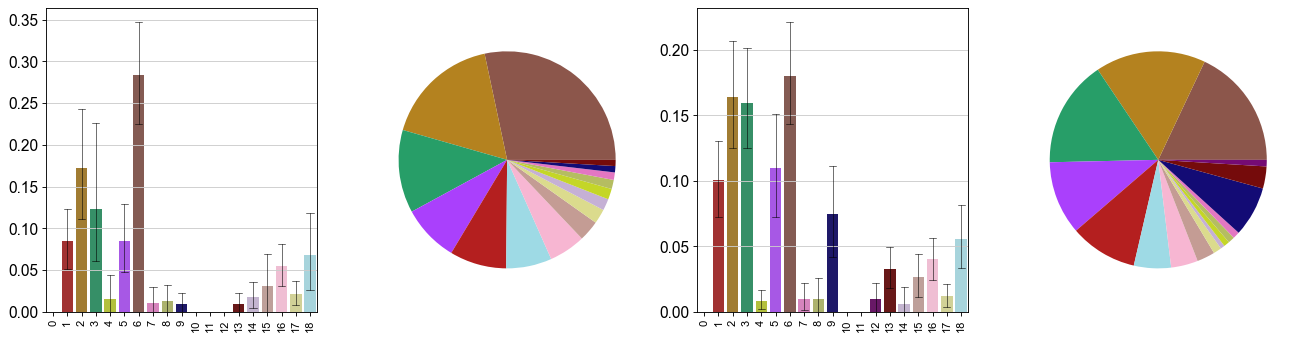

Environment cluster 4


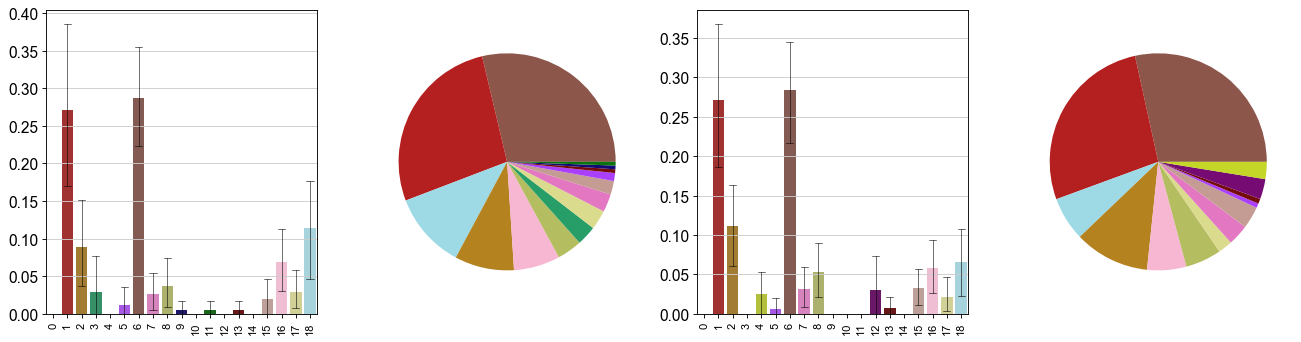

Environment cluster 5


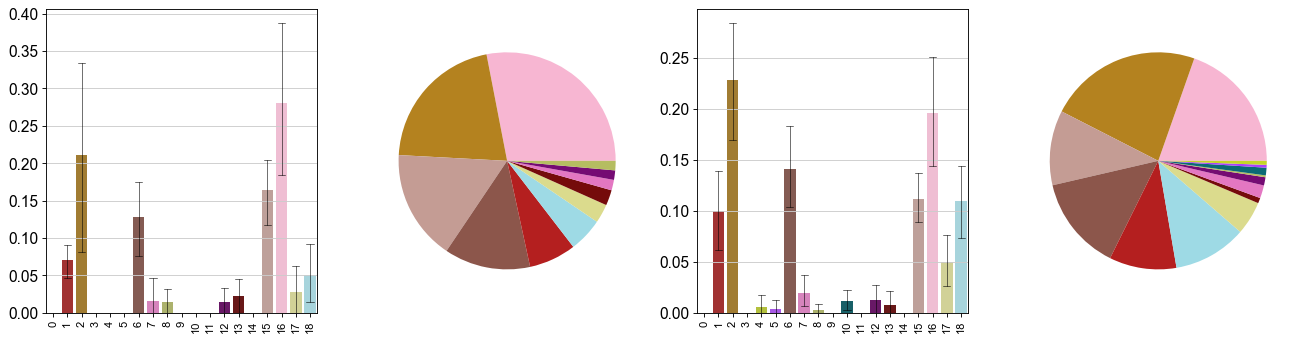

In [65]:
for j in range(adata_neighbour_CD3_noprot.obs.leiden_CD3_neighbour.unique().shape[0]):
    print('Environment cluster '+str(j))
    df_CD4=pd.DataFrame()
    df_CD8=pd.DataFrame()
    for cell in adata_neighbour_CD3_noprot[adata_neighbour_CD3_noprot.obs.leiden_CD3_neighbour==str(j)].obs_names.values:
        if adata.obs.loc[cell]['celltype_Level_2']=='CD4 T cells':
            data=pd.DataFrame(adata.obs[adata.obs_names.isin(distances_completed_na.loc[distances_completed_na[cell]<=(2*x),cell].index.values.astype(str))]["celltype_Level_2"].value_counts())
            data=data/data[data['celltype_Level_2']>0].sum()
            df_CD4=pd.concat([df_CD4,data], axis=1)
            
        if adata.obs.loc[cell]['celltype_Level_2']=='CD8 T cells':
            data=pd.DataFrame(adata.obs[adata.obs_names.isin(distances_completed_na.loc[distances_completed_na[cell]<=(2*x),cell].index.values.astype(str))]["celltype_Level_2"].value_counts())
            data=data/data[data['celltype_Level_2']>0].sum()
            df_CD8=pd.concat([df_CD8,data], axis=1)
            
    fig,ax=plt.subplots(ncols=4, figsize=(20,5))
    sns.barplot(data=df_CD4.T, palette=adata_neigbours_only.uns['celltype_Level_2_colors'], errwidth=0.5,errcolor='black',capsize=0.5, ax=ax[0])
    ax[0].set_xticklabels(df.index,rotation=90,size=10)
    
    data_CD4=pd.DataFrame(df_CD4.mean(axis=1), columns=['value'])
    data_CD4['color']=adata_neigbours_only.uns['celltype_Level_2_colors']
    data_CD4=data_CD4.sort_values('value', ascending=False)
    ax[1].pie(data_CD4.value, colors=data_CD4.color)
    
    sns.barplot(data=df_CD8.T, palette=adata_neigbours_only.uns['celltype_Level_2_colors'], errwidth=0.5,errcolor='black',capsize=0.5, ax=ax[2])
    ax[2].set_xticklabels(df.index,rotation=90,size=10)
    
    data=pd.DataFrame(df_CD8.mean(axis=1), columns=['value'])
    data['color']=adata_neigbours_only.uns['celltype_Level_2_colors']
    data['values_CD4']=data_CD4['value']
    data=data.sort_values('values_CD4', ascending=False)
    ax[3].pie(data.value, colors=data.color)

    plt.show()

In [66]:
adata_CD3_prot=adata_neighbour_CD3[:,adata_neighbour_CD3.var.feature_types=='gene_expression']
adata_CD3_prot.obs['leiden_CD3_neighbour']=adata_neighbour_CD3_noprot.obs['leiden_CD3_neighbour']

Trying to set attribute `.obs` of view, copying.


In [67]:
sc.tl.pca(adata_CD3_prot, svd_solver='arpack');

In [68]:
sc.pp.neighbors(adata_CD3_prot, n_neighbors=10, n_pcs=20)

In [69]:
sc.tl.umap(adata_CD3_prot, min_dist=1)

In [70]:
sc.tl.leiden(adata_CD3_prot, key_added='leiden_CD3_prot', resolution=0.3)

... storing 'feature_types' as categorical


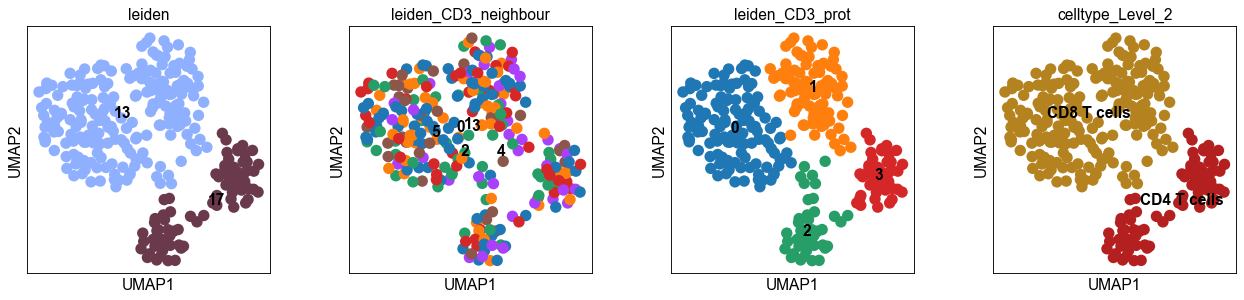

In [71]:
sc.pl.umap(adata_CD3_prot, color=['leiden','leiden_CD3_neighbour','leiden_CD3_prot','celltype_Level_2'], legend_loc='on data')

In [72]:
adata_CD3_prot.obs['T_cell_pop']='no'
adata_CD3_prot.obs.T_cell_pop[adata_CD3_prot.obs.leiden_CD3_prot=='0']='naive CD8'
adata_CD3_prot.obs.T_cell_pop[adata_CD3_prot.obs.leiden_CD3_prot=='1']='memory CD8'
adata_CD3_prot.obs.T_cell_pop[adata_CD3_prot.obs.leiden_CD3_prot=='2']='naive CD4'
adata_CD3_prot.obs.T_cell_pop[adata_CD3_prot.obs.leiden_CD3_prot=='3']='memory CD4'

... storing 'T_cell_pop' as categorical
/Users/Sebastian/miniconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


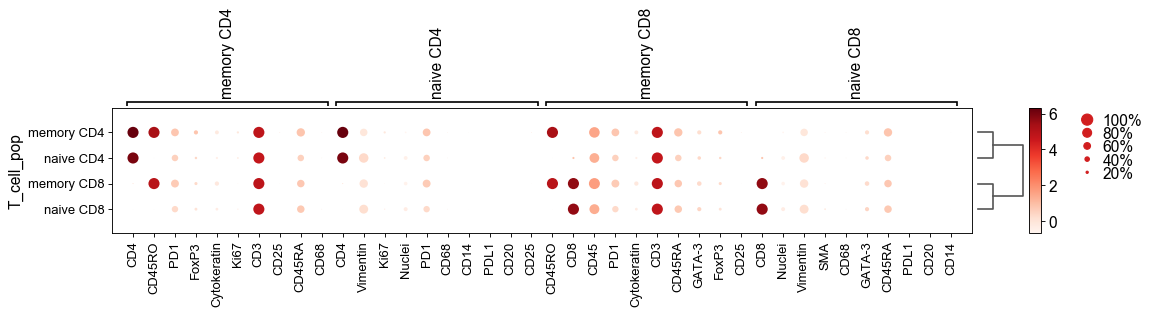

In [73]:
sc.tl.rank_genes_groups(adata_CD3_prot, 'T_cell_pop', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata_CD3_prot, n_genes=10)

## Subgroup to CD4 positive cells

In [74]:
adata_CD4_prot=adata_CD3_prot[adata_CD3_prot.obs.celltype_lymphocytes.isin(['CD4 T cells'])]

In [75]:
sc.tl.pca(adata_CD4_prot, svd_solver='arpack');

In [76]:
sc.pp.neighbors(adata_CD4_prot, n_neighbors=50, n_pcs=5)

In [77]:
sc.tl.umap(adata_CD4_prot)

In [78]:
sc.tl.leiden(adata_CD4_prot, key_added='leiden_CD4_prot', resolution=1)

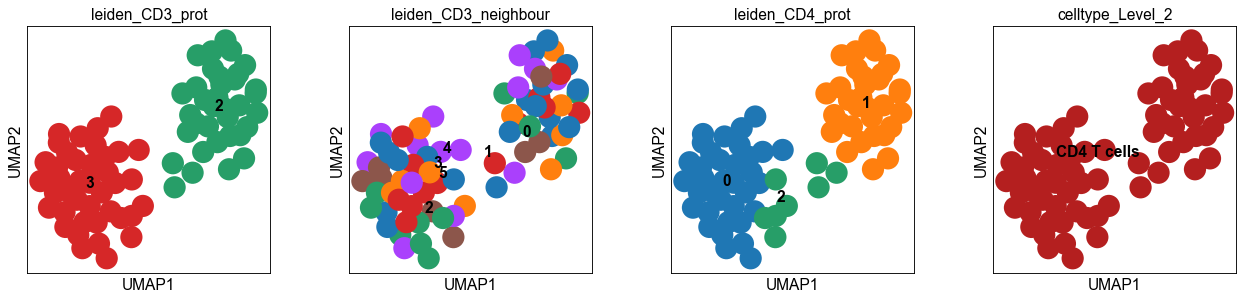

In [79]:
sc.pl.umap(adata_CD4_prot, color=['leiden_CD3_prot','leiden_CD3_neighbour','leiden_CD4_prot','celltype_Level_2'], legend_loc='on data')

/Users/Sebastian/miniconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


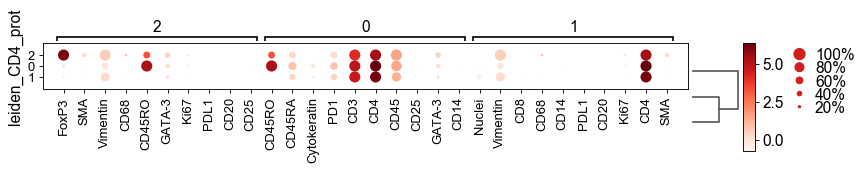

In [80]:
sc.tl.rank_genes_groups(adata_CD4_prot, 'leiden_CD4_prot', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata_CD4_prot, n_genes=10)

In [81]:
adata_CD3_prot.obs['T_cell_pop']=adata_CD3_prot.obs['T_cell_pop'].astype(str)
adata_CD3_prot.obs.T_cell_pop[adata_CD3_prot.obs_names.isin(adata_CD4_prot[adata_CD4_prot.obs.leiden_CD4_prot=='2'].obs_names)]='Tregs'

... storing 'T_cell_pop' as categorical


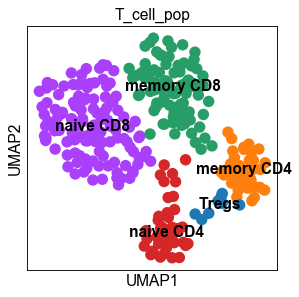

In [82]:
sc.pl.umap(adata_CD3_prot, color='T_cell_pop', legend_loc='on data')

In [83]:
adata_neighbour_CD3_noprot.obs['T_cell_pop']=adata_CD3_prot.obs.T_cell_pop

In [84]:
neighbours_for_plot=neighbours/1000

In [85]:
neighbours_for_plot_CD3=neighbours_for_plot[neighbours_for_plot.index.isin(adata_neighbour_CD3_noprot.obs_names)]

In [86]:
neighbours_for_plot_CD3.to_csv('./export/raw_neighbours_CD3.csv')

In [87]:
adata_CD3_forplot = sc.read_csv('./export/raw_neighbours_CD3.csv',first_column_names=True)

In [88]:
adata_CD3_forplot.obs=adata_neighbour_CD3_noprot.obs

In [89]:
adata_CD3_forplot

AnnData object with n_obs × n_vars = 284 × 35 
    obs: 'X', 'Y', 'area', 'circularity', 'Annotation', 'Gated_population_1', 'Gated_population_2', 'n_genes', 'brightness_total', 'leiden', 'celltype_Level_1', 'celltype_epithelial', 'celltype_muscular', 'celltype_lymphocytes', 'celltype_Level_2', 'leiden_CD3_neighbour', 'T_cell_pop'

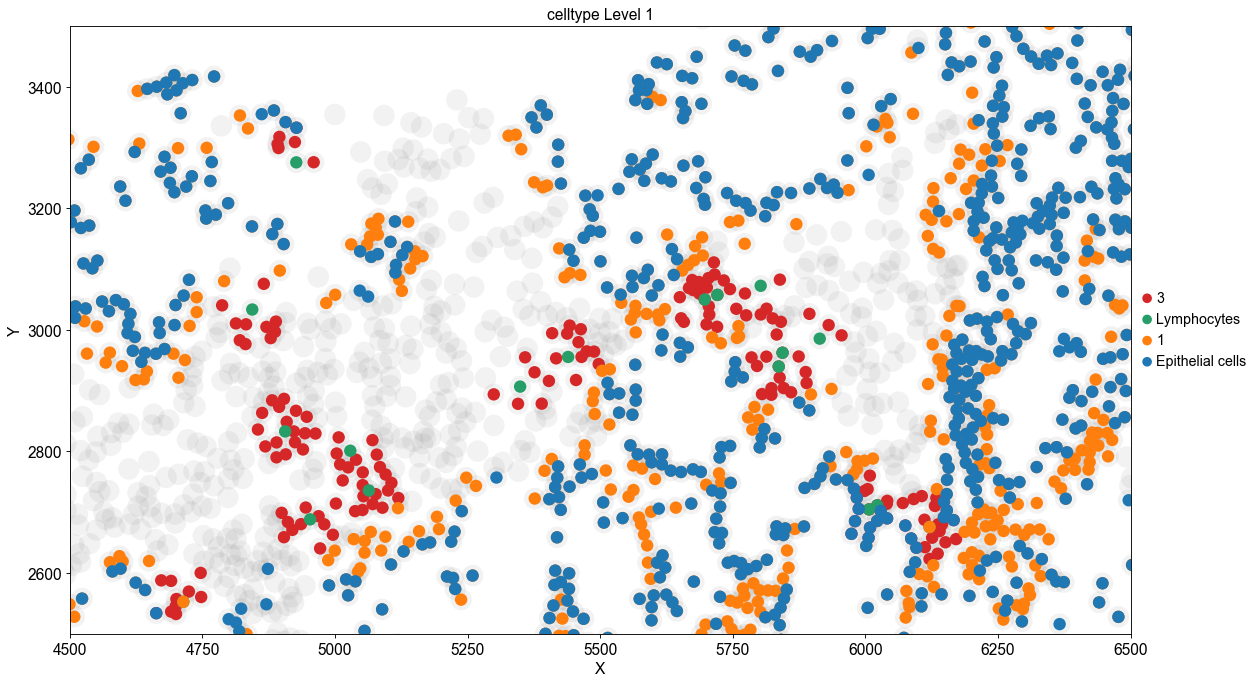

In [90]:
fig, ax = plt.subplots(figsize=(17, 10))
ax.set_xlim([4500,6500])
ax.set_ylim([2500,3500])
sc.pl.scatter(adata, 'X', 'Y', size=1500, alpha=0.1, ax=ax, show=False)
sc.pl.scatter(adata_neigbours_only[adata_neigbours_only.obs.leiden_neighbours=='3'], 'X', 'Y', color='leiden_neighbours', size=500, ax=ax, show=False)
sc.pl.scatter(adata[adata.obs.leiden=='35'], 'X', 'Y', color='celltype_Level_1', size=500, ax=ax, show=False)
sc.pl.scatter(adata_neigbours_only[adata_neigbours_only.obs.leiden_neighbours=='1'], 'X', 'Y', color='leiden_neighbours', size=500, ax=ax, show=False)
sc.pl.scatter(adata[adata.obs.celltype_Level_1=='Epithelial cells'], 'X', 'Y', color='celltype_Level_1', size=500, ax=ax, show=False)

ax.grid(False)

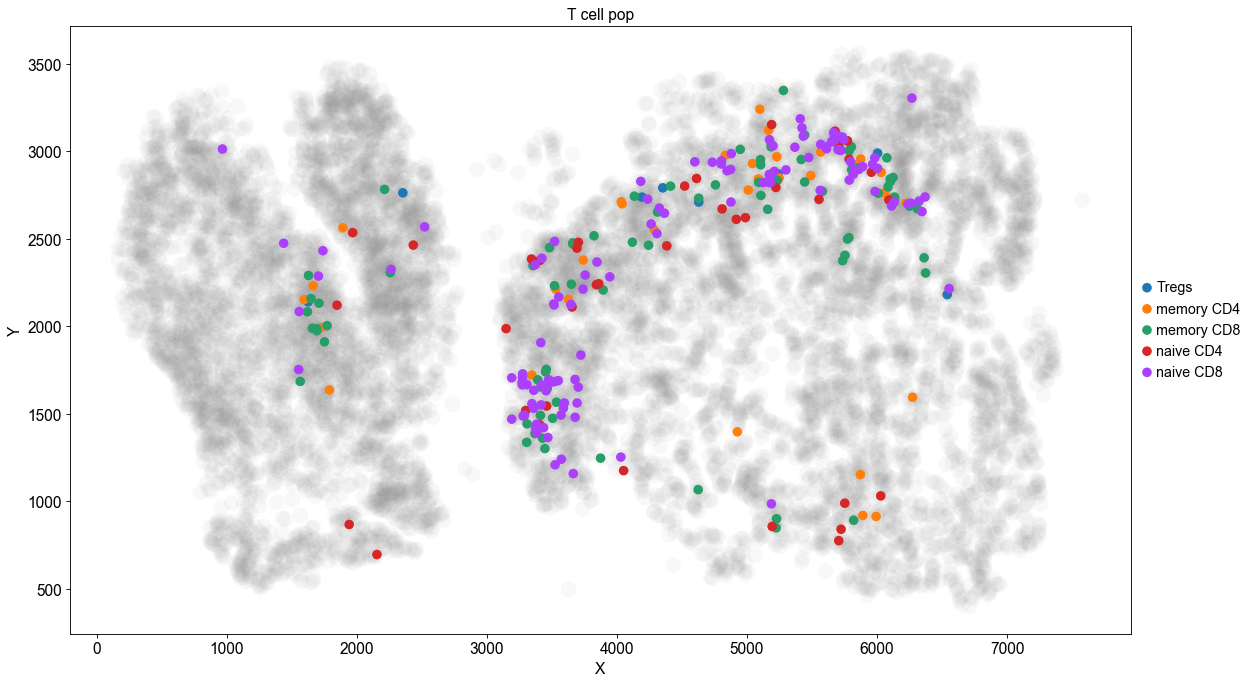

In [91]:
fig, ax = plt.subplots(figsize=(17, 10))
sc.pl.scatter(adata, 'X', 'Y', size=800, alpha=0.05, ax=ax, show=False)
sc.pl.scatter(adata_neighbour_CD3_noprot, 'X', 'Y', color='T_cell_pop', size=300, ax=ax, show=False)
ax.grid(False)

## Narrow down radius to interaction

In [92]:
cells_of_interest = ['9395','2397','2609','13019'] #cells selected from different tissue regions
x=20 #set the radius (represents a 30µm range)

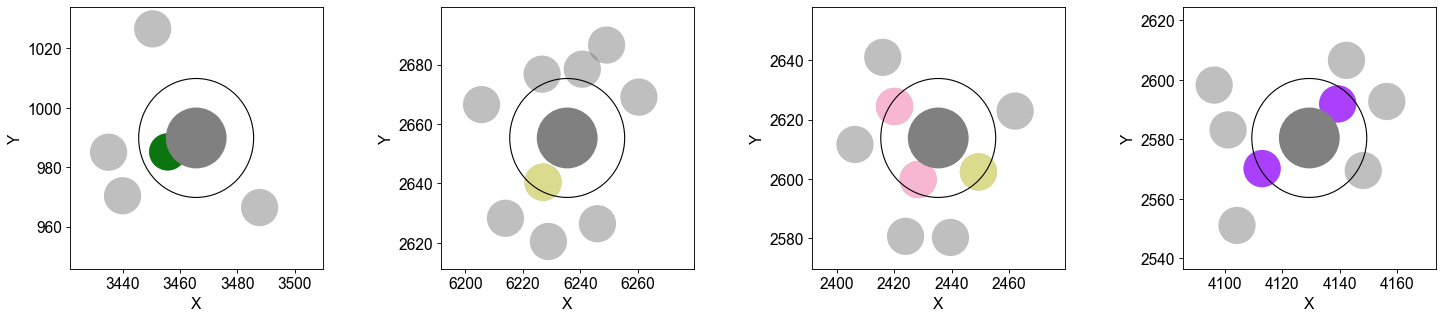

In [93]:
fig, ax = plt.subplots(ncols=4, figsize=(18, 4))
fig.tight_layout(w_pad=5)
for i, cell in enumerate(cells_of_interest):
    ax[i].set_xlim([adata.obs.loc[cell]['X']-2.2*x,adata.obs.loc[cell]['X']+2.2*x])
    ax[i].set_ylim([adata.obs.loc[cell]['Y']-2.2*x,adata.obs.loc[cell]['Y']+2.2*x])
    circle = plt.Circle((adata.obs.loc[cell]['X'], adata.obs.loc[cell]['Y']), x, edgecolor="black", facecolor='none')
    sc.pl.scatter(adata[adata.obs_names.isin(distances_completed.loc[distances_completed[cell]<=(2*x),cell].index.values.astype(str))], 'X', 'Y', size=4500, alpha=0.5, ax=ax[i], show=False)
    sc.pl.scatter(adata[adata.obs_names.isin(distances_completed.loc[distances_completed[cell]<=x,cell].index.values.astype(str))], 'X', 'Y', color='celltype_Level_2', size=4500, ax=ax[i], show=False)
    sc.pl.scatter(adata[adata.obs_names.isin([cell])], 'X', 'Y', size=12000, ax=ax[i], show=False)
    ax[i].add_artist(circle)
    ax[i].grid(False)
    ax[i].get_legend().remove()

In [94]:
distances_completed_na[distances_completed_na>=x]=np.nan

In [95]:
neighbours=pd.DataFrame()
for i in range(adata.obs.leiden.nunique()):
    neighbours[i]=distances_completed_na.loc[:,adata.obs_names[adata.obs.leiden==np.sort(adata.obs.leiden.unique().astype(int)).astype(str)[i]].values].count(axis=1)

In [96]:
neighbours=neighbours*1000

In [97]:
#Process and merge the adata.var matrix with the distance matrix
var_data.columns=adata.var_names
var_data.index=neighbours.index
neighbours.columns=colnames
var_data_merged_interaction=pd.concat([neighbours, var_data], axis=1)
var_data_merged_interaction=var_data_merged_interaction[var_data_merged_interaction.index.isin(adata.obs_names)]
var_data_merged_interaction.to_csv('./export/var_data_merged_interaction.csv', index=False)
adata_interaction=sc.read_csv('./export/var_data_merged_interaction.csv')
sc.pp.normalize_total(adata_interaction, target_sum=1e4)
sc.pp.log1p(adata_interaction)
sc.pp.scale(adata_interaction, max_value=10)
adata_interaction.obs=adata_neigbours_only.obs
adata_interaction.uns=adata_neigbours_only.uns
adata_interaction.var['feature_types']='gene_expression'
adata_interaction.var['feature_types'][:adata_interaction.obs.leiden.nunique()]='distance'

In [98]:
adata_interaction_only=adata_interaction[:,adata_interaction.var.feature_types=='distance']
adata_interaction_only.obs['n_counts'] = adata_interaction_only.X.sum(axis=1)

Trying to set attribute `.obs` of view, copying.


In [99]:
sc.tl.pca(adata_interaction_only, svd_solver='arpack');

In [100]:
sc.pp.neighbors(adata_interaction_only, n_neighbors=100, n_pcs=20)

/Users/Sebastian/miniconda3/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../miniconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


In [101]:
sc.tl.umap(adata_interaction_only, min_dist=1.5)

/Users/Sebastian/miniconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


In [102]:
sc.tl.leiden(adata_interaction_only, key_added='leiden_interaction', resolution=5)

In [103]:
groups=list(np.arange(0,39))
groups=groups + [40,83,92,93,95,96,99,110,117,124,125,126]
groups = [str(i) for i in groups]

In [104]:
adata_interaction_only.obs['leiden_interaction_anno']='no_interaction'
j=0
for i in groups:
    adata_interaction_only.obs.leiden_interaction_anno[adata_interaction_only.obs.leiden_interaction==i]=str(j)
    j=j+1

... storing 'leiden_interaction_anno' as categorical
... storing 'feature_types' as categorical


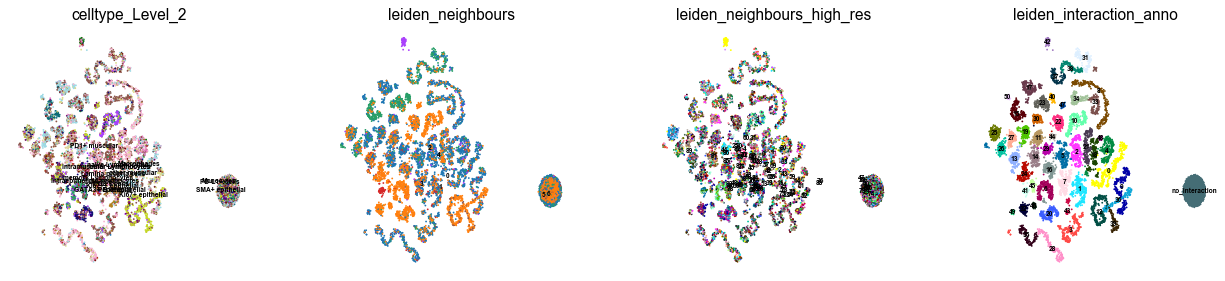

In [105]:
sc.pl.umap(adata_interaction_only, color=['celltype_Level_2','leiden_neighbours','leiden_neighbours_high_res','leiden_interaction_anno'], legend_loc='on data', legend_fontsize=6, frameon=False)

In [106]:
def plot_interactions(cell, ax):
    x=20
    ax.set_xlim([adata.obs.loc[cell]['X']-1.2*x,adata.obs.loc[cell]['X']+1.2*x])
    ax.set_ylim([adata.obs.loc[cell]['Y']-1.2*x,adata.obs.loc[cell]['Y']+1.2*x])
    sc.pl.scatter(adata[adata.obs_names.isin(distances_completed_na.loc[distances_completed_na[cell]<=(2*x),cell].index.values.astype(str))], 'X', 'Y', size=1200, alpha=0.5, ax=ax, show=False)
    sc.pl.scatter(adata[adata.obs_names.isin(distances_completed_na.loc[distances_completed_na[cell]<=x,cell].index.values.astype(str))], 'X', 'Y', color='celltype_Level_2', size=1200, ax=ax, show=False)
    sc.pl.scatter(adata[adata.obs_names.isin([cell])], 'X', 'Y', size=2400, ax=ax, show=False)
    ax.grid(False)
    ax.get_legend().remove()
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_xlabel('')

Interaction cluster 26


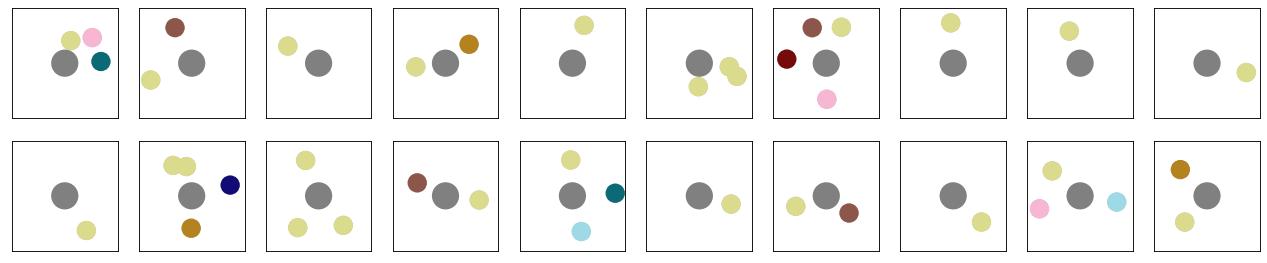

Interaction cluster 33


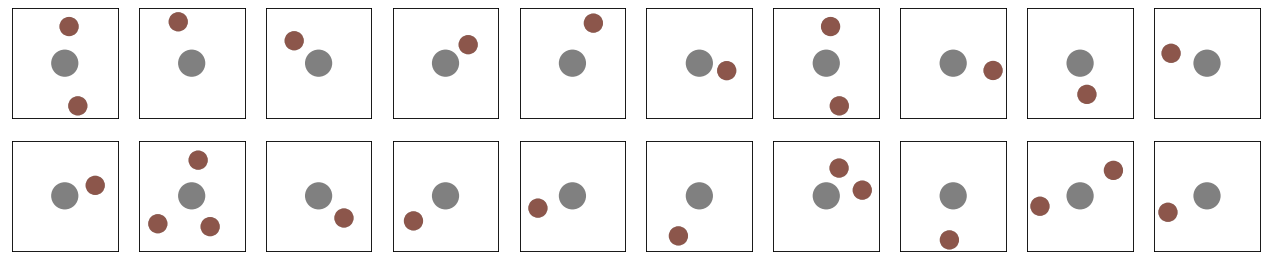

Interaction cluster 50


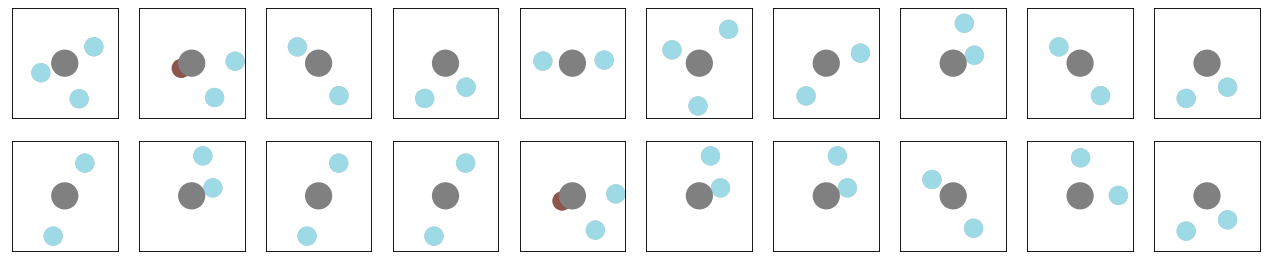

Interaction cluster 25


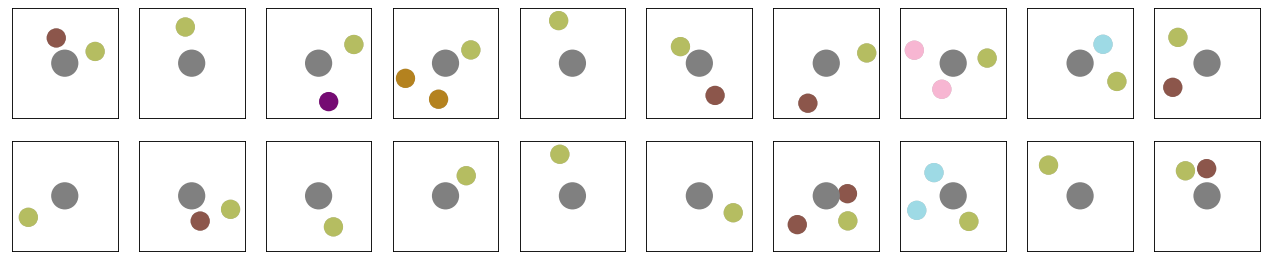

Interaction cluster 3


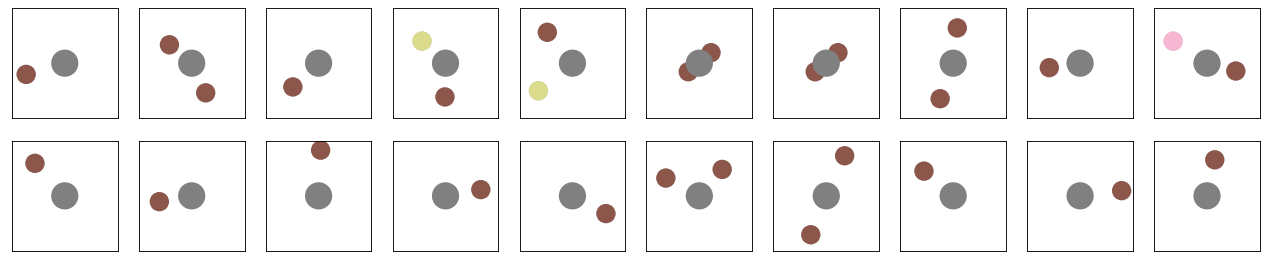

In [107]:
for j in np.random.choice(adata_interaction_only.obs.leiden_interaction_anno.unique().sort_values()[1:], size=5):
    print('Interaction cluster '+str(j))
    fig, ax = plt.subplots(ncols=10,nrows=2, figsize=(20,4))
    i=0
    for cell in np.random.choice(adata_interaction_only[adata_interaction_only.obs.leiden_interaction_anno==str(j)].obs_names.values, size=20):
        plot_interactions(cell, ax.reshape(-1)[i])
        i=i+1
    plt.show()

## Subgroup to CD3 positive cells

In [108]:
adata_interaction_CD3=adata_interaction[adata_interaction.obs.celltype_lymphocytes.isin(['CD4 T cells', 'CD8 T cells'])]
adata_interaction_CD3=adata_interaction_CD3[adata_interaction_CD3[: , 'CD3'].X.toarray()[:,0] >=0.5, :] 
adata_interaction_CD3=adata_interaction_CD3[:,adata_interaction_CD3.var.feature_types=='distance']
adata_interaction_CD3.obs=adata_interaction_CD3.obs.join(adata_CD3_prot.obs.T_cell_pop)

In [109]:
sc.tl.pca(adata_interaction_CD3, svd_solver='arpack');

In [110]:
sc.pp.neighbors(adata_interaction_CD3, n_neighbors=50, n_pcs=10)

In [111]:
sc.tl.umap(adata_interaction_CD3, min_dist=0.8)

In [112]:
sc.tl.leiden(adata_interaction_CD3, key_added='leiden_CD3_interaction', resolution=0.6)

... storing 'feature_types' as categorical


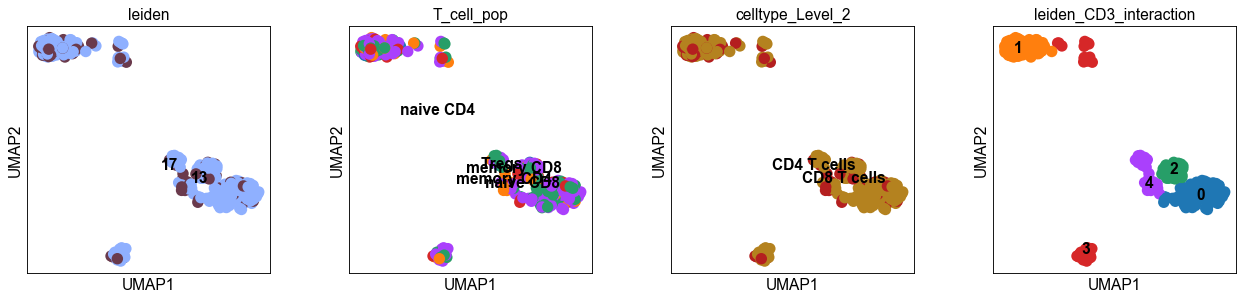

In [113]:
sc.pl.umap(adata_interaction_CD3, color=['leiden','T_cell_pop','celltype_Level_2','leiden_CD3_interaction'], legend_loc='on data')

/Users/Sebastian/miniconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


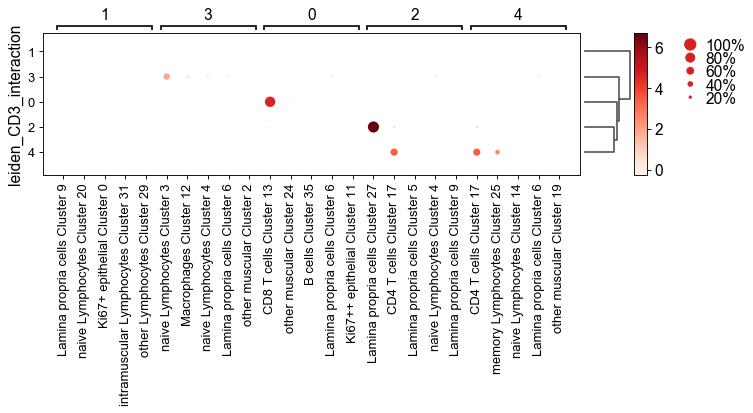

In [114]:
sc.tl.rank_genes_groups(adata_interaction_CD3, 'leiden_CD3_interaction', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata_interaction_CD3, n_genes=5)

In [115]:
neighbours_for_plot=neighbours/1000

In [116]:
neighbours_for_plot_CD3=neighbours_for_plot[neighbours_for_plot.index.isin(adata_neighbour_CD3_noprot.obs_names)]

In [117]:
neighbours_for_plot_CD3.to_csv('./export/raw_neighbours_CD3_interaction.csv')

In [118]:
adata_CD3_forplot = sc.read_csv('./export/raw_neighbours_CD3_interaction.csv',first_column_names=True)

In [119]:
adata_CD3_forplot.obs=adata_interaction_CD3.obs

In [120]:
adata_CD3_forplot.obs['T_cell_pop']=adata_CD3_prot.obs['T_cell_pop']

In [121]:
adata_CD3_forplot=adata_CD3_forplot[adata_CD3_forplot.X.sum(axis=1)>=1]

In [122]:
result_list=[]
z=0.05
for populations in adata_CD3_forplot.obs.T_cell_pop.unique():
    list_new=adata_CD3_forplot.var_names[adata_CD3_forplot[adata_CD3_forplot.obs.T_cell_pop=='memory CD4'].X.mean(axis=0)>z]
    result_list.extend(x for x in list_new if x not in result_list)

In [123]:
result_list.sort()

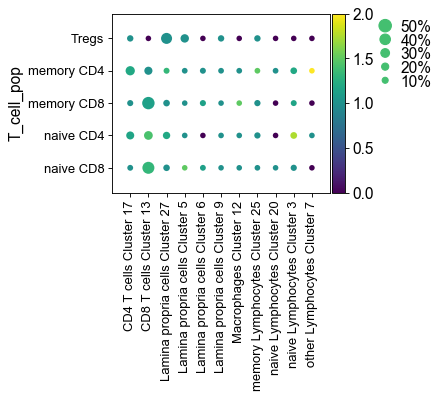

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[3.55, 0, 0.2, 0.5, 0.25])

In [124]:
sc.pl.dotplot(adata_CD3_forplot, var_names=result_list, groupby='T_cell_pop',smallest_dot=25, mean_only_expressed=True, color_map='viridis', use_raw=False, dot_max=0.5, figsize=(4.5,3))

Population naive CD4


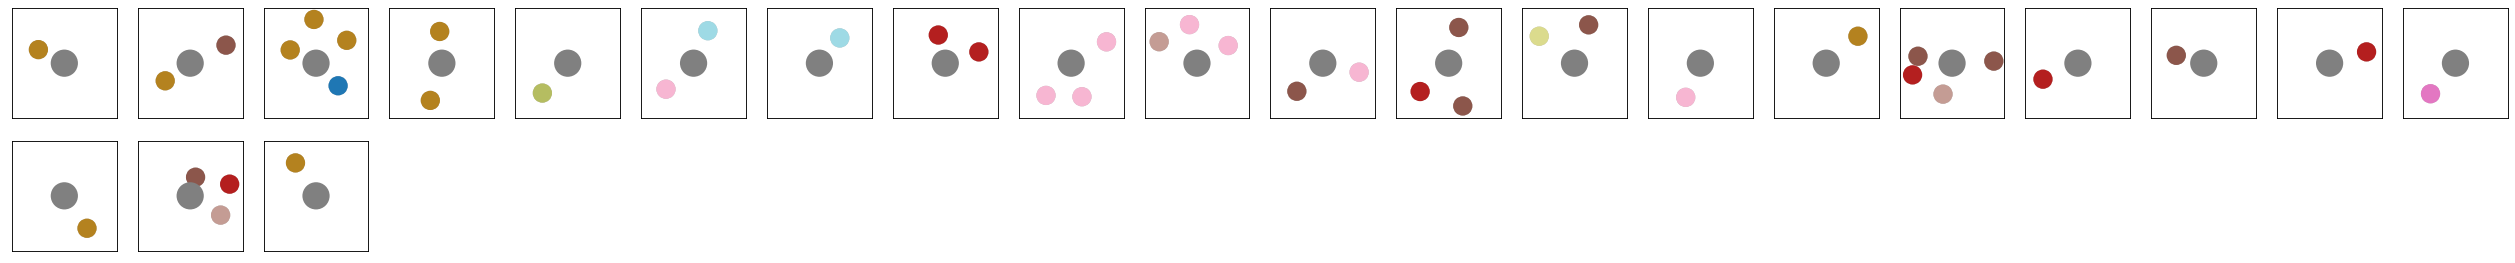

Population memory CD4


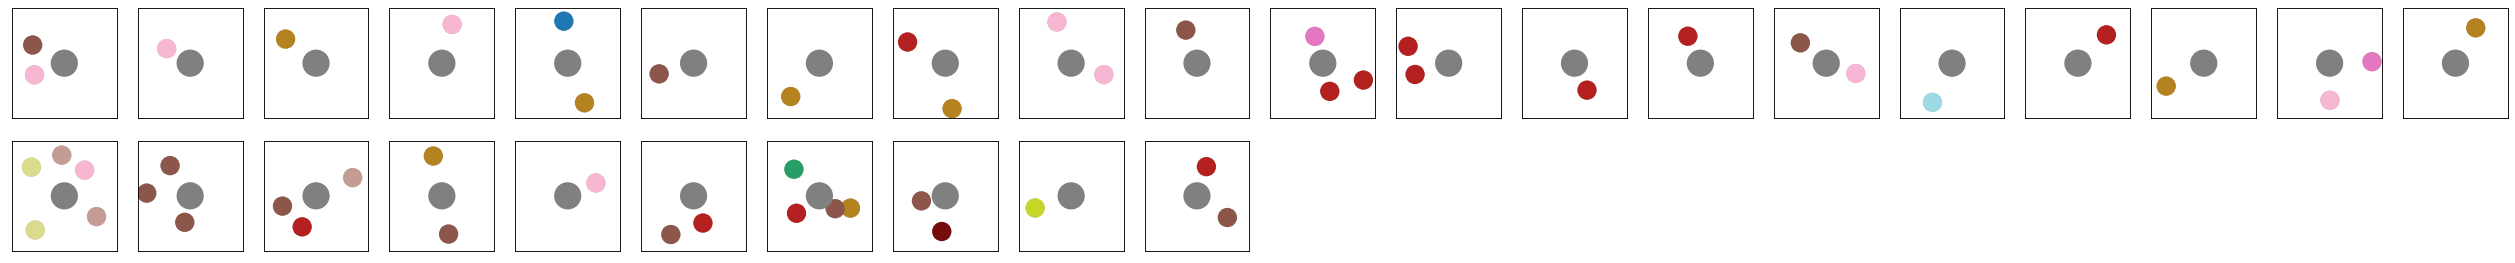

Population naive CD8


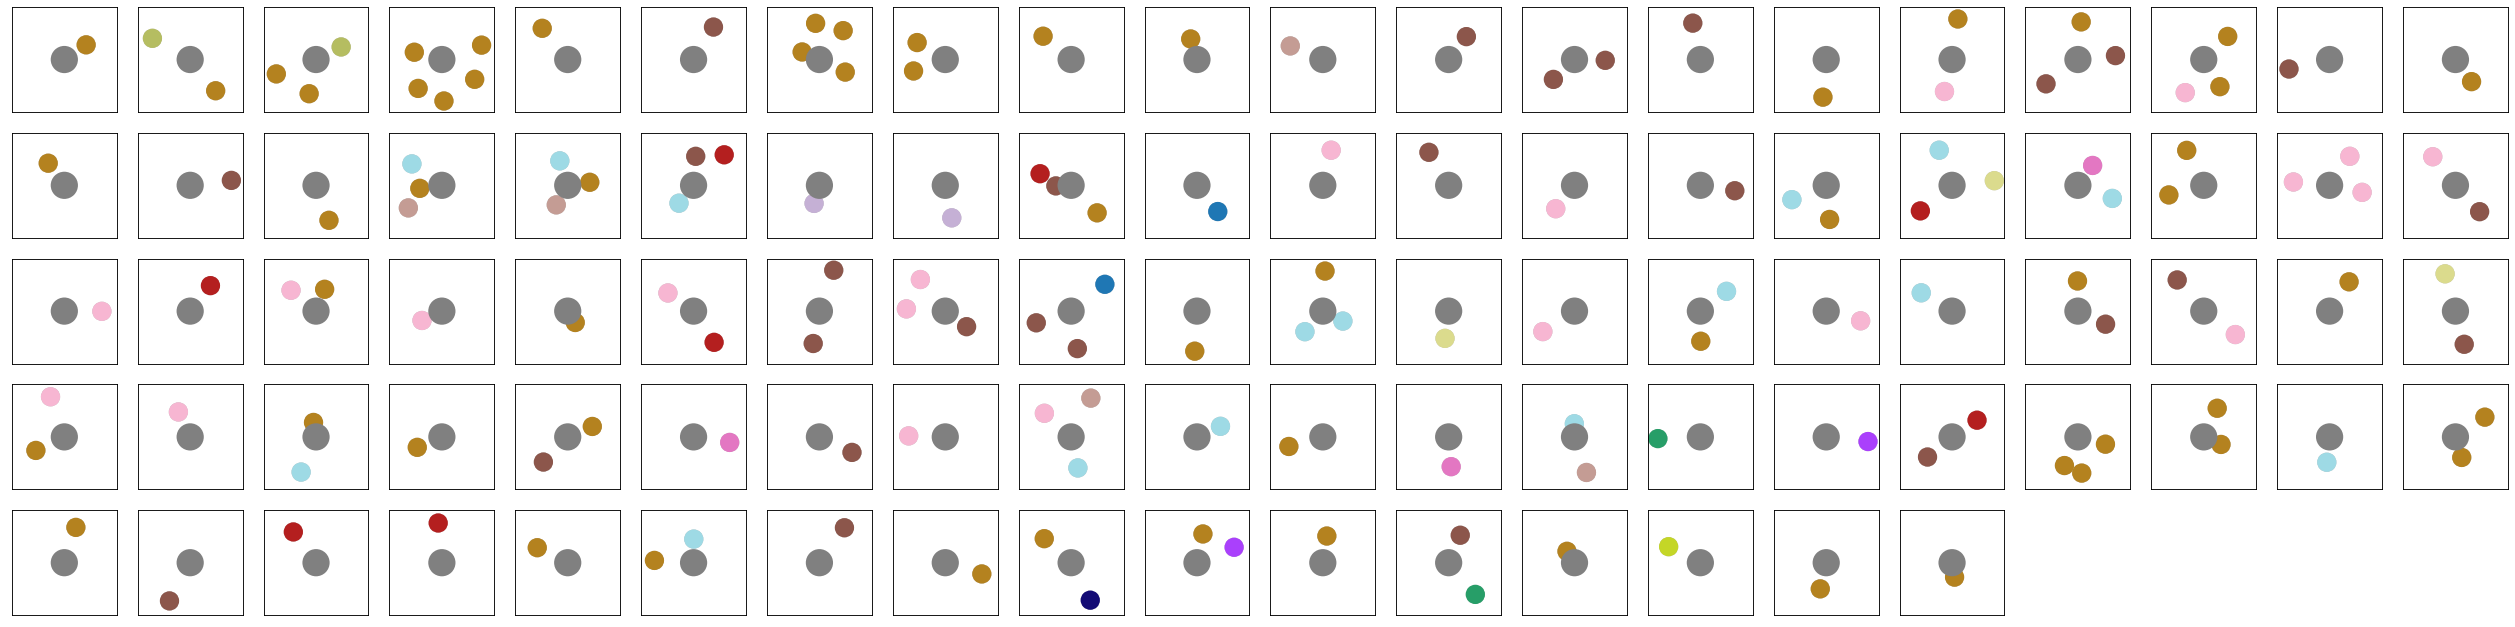

Population memory CD8


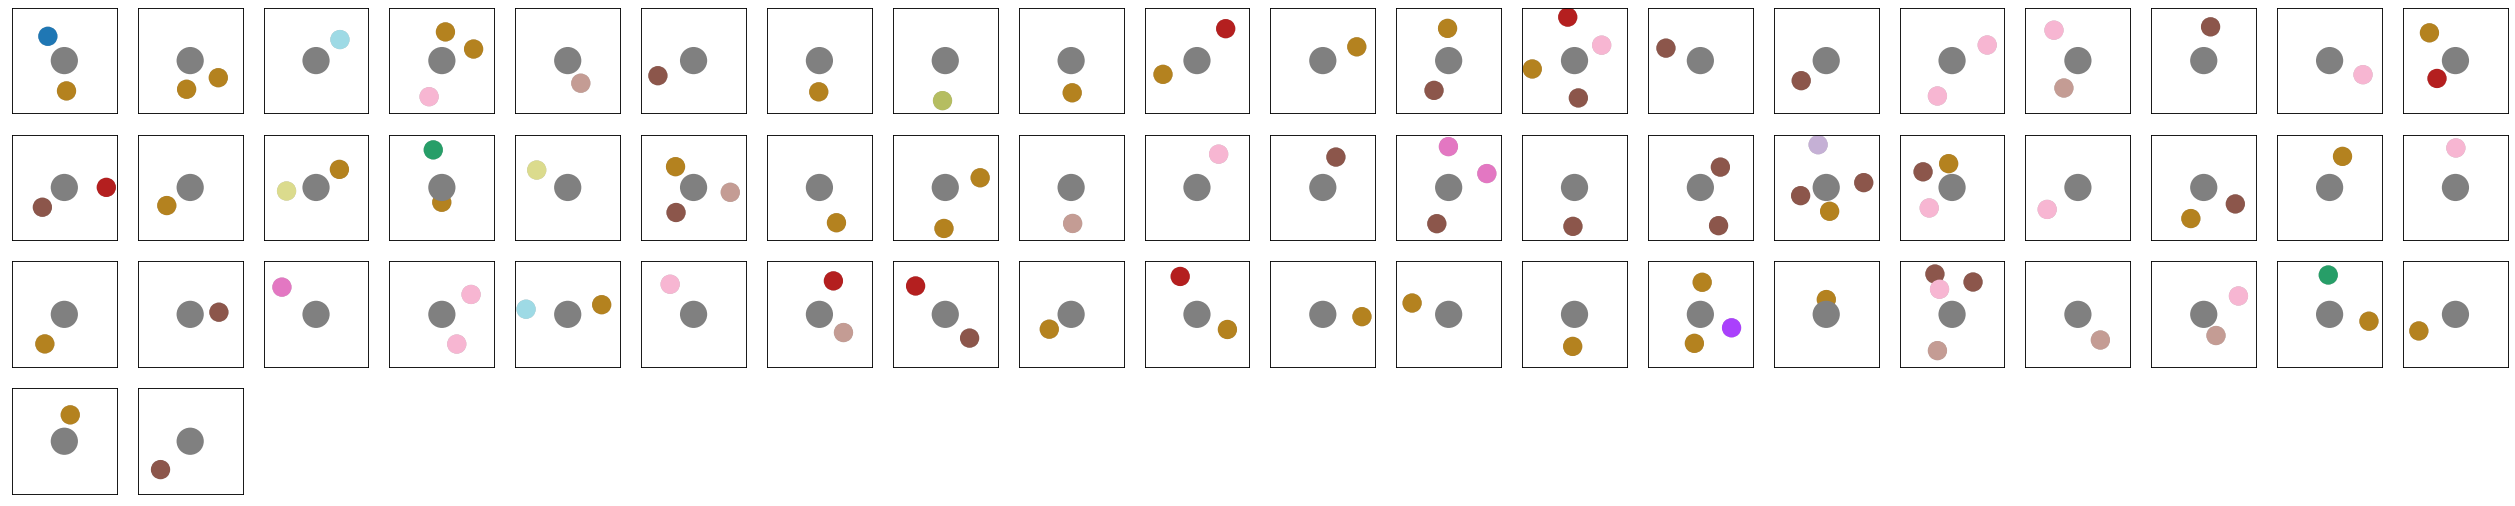

Population Tregs


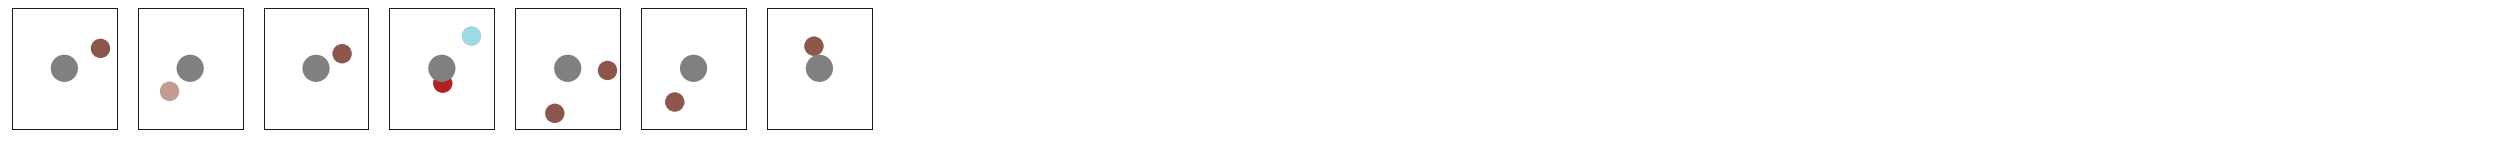

In [125]:
for pop in adata_CD3_forplot.obs.T_cell_pop.unique().sort_values():
    print('Population '+str(pop))
    rows = adata_CD3_forplot[adata_CD3_forplot.obs.T_cell_pop==str(pop)].shape[0]//20+1
    fig, ax = plt.subplots(ncols=20,nrows=rows, figsize=(40,rows*2))

    for i, cell in enumerate(adata_CD3_forplot[adata_CD3_forplot.obs.T_cell_pop==str(pop)].obs_names.values):
        plot_interactions(cell, ax.reshape(-1)[i])
    
    [axi.set_axis_off() for axi in ax.reshape(-1)[adata_CD3_forplot[adata_CD3_forplot.obs.T_cell_pop==str(pop)].shape[0]:]]
    plt.show()